In [1]:
# Standard library
import importlib
import math
# Third-party libraries
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from scipy.stats import norm
import seaborn as sns
from tqdm import tqdm

# Local modules
import gm_utils
importlib.reload(gm_utils)  # Forces Python to reload updated gm_utils.py
from gm_utils import visualize_density, sample, geodesic, energy
from curves import CubicSpline

# Matplotlib settings
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

# 2D EXPERIMENTS

Things to do: 
- Compare geodesics and pf-ode for different dimensions
- Make sure geodesic is outputing stuff in 3D.

In [2]:
def gaussian_mixture_density(x, t):
    """
    Analytical marginal log-density for 2D Gaussian mixture.
    x: (B, 2)
    t: (B,)
    """
    alpha_t, sigma_t = alpha_sigma(t)           
    
    means_t = alpha_t[:, None, None] * original_means[None, :, :]  # (B, num_components, 2)
    variances_t = sigma_t[:, None]**2 + alpha_t[:, None]**2 * original_variance  # (B, num_components)

    # Compute log probability for each component
    diff = x[:, None, :] - means_t  
    log_gauss = -0.5 * (torch.log(2 * torch.pi * variances_t[:, :, None]) + (diff**2).sum(dim=2)/variances_t[:, :, None])  # (B, num_components, 1)
    log_gauss = log_gauss.squeeze(-1)  

    log_probs = torch.log(weights[None, :]) + log_gauss  # (B, num_components)
    log_p_t = torch.logsumexp(log_probs, dim=1)  # (B,)
    return log_p_t



def compute_vector_field(x, t):
    """
    PF-ODE vector field for any alpha_sigma(t)
    x: (B, D)
    t: (B,)
    """
    x = x.clone().detach().requires_grad_(True)
    t = t.clone().detach().requires_grad_(True)

    alpha_t, sigma_t = alpha_sigma(t)

    log_alpha = torch.log(alpha_t)
    f_t = torch.autograd.grad(log_alpha.sum(), t, create_graph=True)[0]  # (B,)

    lambda_t = torch.log(alpha_t**2 / sigma_t**2)
    dlambda_dt = torch.autograd.grad(lambda_t.sum(), t, create_graph=True)[0]
    g2_t = -sigma_t**2 * dlambda_dt  # (B,)

    log_p_t = gaussian_mixture_density(x, t)  # (B,)
    grad_log_p_t = torch.autograd.grad(
        log_p_t.sum(), x, create_graph=True
    )[0]  # (B, D)

    dx = f_t[:, None] * x - 0.5 * g2_t[:, None] * grad_log_p_t  # (B, D)
    dt = -torch.ones_like(t)  # (B,)

    return dt, dx



def sample(x, n_steps, t_start=1.0, t_end=0.0):
    B, D = x.shape
    t = t_start * torch.ones(B, dtype=x.dtype, device=x.device)
    dt_val = (t_start - t_end) / n_steps

    all_x = [x.detach().cpu().numpy()]
    all_t = [t.detach().cpu().numpy()]

    for _ in range(n_steps):
        dt, dx = compute_vector_field(x, t)
        x = x + dx * dt_val
        t = t + dt * dt_val

        all_x.append(x.detach().cpu().numpy())
        all_t.append(t.detach().cpu().numpy())

    return np.array(all_t), np.array(all_x)


def compute_vector_field(x, t):
    """
    Probability Flow ODE vector field
    x: (B, D)
    t: (B,)
    returns dx/dt: (B, D)
    """
    x = x.clone().detach().requires_grad_(True)
    t = t.clone().detach().requires_grad_(True)

    alpha_t, sigma_t = alpha_sigma(t)

    # f(t) = d/dt log α(t)
    log_alpha = torch.log(alpha_t)
    f_t = torch.autograd.grad(log_alpha.sum(), t, create_graph=True)[0]  # (B,)

    # g(t)^2
    lambda_t = torch.log(alpha_t**2 / sigma_t**2)
    dlambda_dt = torch.autograd.grad(lambda_t.sum(), t, create_graph=True)[0]
    g2_t = -sigma_t**2 * dlambda_dt  # (B,)

    # score
    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(
        log_p_t.sum(), x, create_graph=True
    )[0]  # (B, D)

    dx = f_t[:, None] * x - 0.5 * g2_t[:, None] * grad_log_p_t
    return dx

def sample(x0, n_steps, t_start=1.0, t_end=0.0):
    B, D = x0.shape
    x = x0.clone()
    t = t_start * torch.ones_like(torch.tensor([1]))

    #t = t_start * torch.ones(B, device=x.device)

    dt = (t_end - t_start) / n_steps  # negative

    all_x = [x.detach().cpu().numpy()]
    all_t = [t.detach().cpu().numpy()]

    for _ in range(n_steps):
        dx = compute_vector_field(x, t)
        x = x + dx * dt
        t = t + dt

        all_x.append(x.detach().cpu().numpy())
        all_t.append(t.detach().cpu().numpy())

    print('all_t', all_t[0], 'all_x', all_x[0])
    return np.array(all_t), np.array(all_x)


def eds(t, x):
    """
    Expected Denoised Sample (EDS) for 2D spatial data
    Args:
        t: (B,) tensor of time values
        x: (B, 2) tensor of spatial values
    Returns:
        res: (B, 2) denoised mean
    """
    assert t.ndim == 1 and x.ndim == 2 and x.shape[0] == t.shape[0]

    alpha_t, sigma_t = alpha_sigma(t)
    x = x.clone().requires_grad_(True)
    
    # Compute score
    log_p_t = gaussian_mixture_density(x, t)  
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x, create_graph=True)[0]

    # Tweedie formula
    res = (x + sigma_t[:, None]**2 * grad_log_p_t) / alpha_t[:, None]
    return res


def mu(theta):
    """
    Expectation parameter for 2D spatial data
    Args:
        theta: (B, 3) tensor where columns = [t, x1, x2]
    Returns:
        mu_t: (B,) tensor
        mu_x: (B, 2) tensor
    """
    t = theta[:, 0]
    x = theta[:, 1:]  # shape (B, 2)
    
    alpha_t, sigma_t = alpha_sigma(t)
    f = eds(t, x)  # shape (B, 2)
    
    div = torch.zeros(t.shape, device=x.device)
    for d in range(x.shape[1]):  # 2D
        div += torch.autograd.grad(f[:, d].sum(), x, create_graph=True)[0][:, d]
    
    mu_t = sigma_t**2 / alpha_t * div + (f**2).sum(dim=1)  
    mu_x = f  # (B, 2)
    return mu_t, mu_x

def eta(theta):
    """
    Natural parameter for 2D spatial data
    Args:
        theta: (B, 3) tensor where columns = [t, x1, x2]
    Returns:
        eta_t: (B,) tensor
        eta_x: (B, 2) tensor
    """
    t = theta[:, 0]
    x = theta[:, 1:] 
    
    alpha_t, sigma_t = alpha_sigma(t)
    
    eta_t = -0.5 * (alpha_t**2 / sigma_t**2)
    eta_x = (alpha_t / sigma_t**2)[:, None] * x
    return eta_t, eta_x



def energy(theta):
    """
    Discretized curve energy (Eq. 23), identical procedure to compute_batch_energy.

    theta : (N, 3) tensor
        Columns are [t, x1, x2]
    """


    mu_t, mu_x = mu(theta)       # (N,), (N, 2)
    eta_t, eta_x = eta(theta) 

    deta_t = eta_t[1:] - eta_t[:-1]    # (N-1,)
    dmu_t  = mu_t[1:]  - mu_t[:-1]     # (N-1,)

    deta_x = eta_x[1:] - eta_x[:-1]    # (N-1, 2)
    dmu_x  = mu_x[1:]  - mu_x[:-1]     # (N-1, 2)

    t_prod = deta_t * dmu_t
    x_prod = deta_x * dmu_x
    t_prod = torch.relu(t_prod)
    x_prod = torch.relu(x_prod)

    x_prod = x_prod.sum(dim=1)  
    return torch.sum(t_prod + x_prod)



def geodesic(theta1, theta2, n_opt_steps, num_intermediate_points, num_nodes=20):
    """
    Approximate geodesic in 2D space + 1D time.
    
    Args:
        theta1: (3,) tensor, first endpoint [t, x1, x2]
        theta2: (3,) tensor, second endpoint [t, x1, x2]
        n_opt_steps: number of optimization steps
        num_intermediate_points: number of discretization points along curve
        num_nodes: number of nodes in CubicSpline
    
    Returns:
        numpy array of shape (num_intermediate_points, 3) representing the optimized curve
    """
    curve = CubicSpline(begin=theta1, end=theta2, num_nodes=num_nodes)  # CubicSpline handles 3D points
    optimizer = torch.optim.Adam(curve.parameters(), lr=1e-1)
    
    t_tensor = torch.linspace(0, 1, num_intermediate_points).unsqueeze(0)  # shape (1, num_points)
    
    for step_id in tqdm(range(n_opt_steps)):
        optimizer.zero_grad()
        theta = curve(t_tensor)[0]  # shape (num_points, 3)
        loss = energy(theta)        # energy() handles 3D points
        loss.backward()
        optimizer.step()
    
    return curve(t_tensor)[0].detach().cpu().numpy()




all_t [0.99] all_x [[-1. -1.]]
all_t [0.99] all_x [[-1. -1.]]
pf_ode: 2
tensor([-4.6136e-07, -4.6136e-07])
pf_ode_theta: tensor([ 9.9863e-03, -4.6136e-07, -4.6136e-07])
Energy of pf ode trajectory: 1376118.0
tensor([-4.6136e-07, -4.6136e-07]) tensor([[-1., -1.]])


100%|██████████| 1000/1000 [00:19<00:00, 50.19it/s]


Energy of the geodesic: 18639.654296875


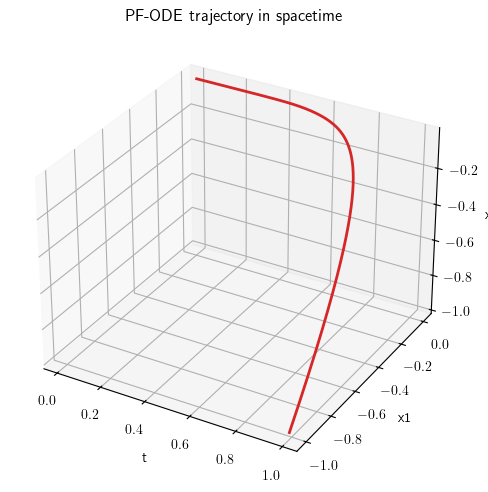

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

theta2 = torch.tensor([[-1, -1]], dtype=torch.float32)
theta2_final = torch.tensor([[1, -1, -1]], dtype=torch.float32)
 
#theta2 = torch.tensor(theta2, dtype=torch.float32)

LAMBDA_MAX, LAMBDA_MIN = 10, -10

original_means = torch.tensor([
    [-1.0, -1.0],  
    [1.0, 1.0]     
], dtype=torch.float32)  
original_variance = torch.tensor(0.00001, dtype=torch.float32)  # isotropic variance
weights = torch.tensor([0.5, 0.5], dtype=torch.float32)      # mixture weights


def log_SNR(t):
    """Implementation of the linear-logSNR noise schedule"""
    return LAMBDA_MAX + (LAMBDA_MIN - LAMBDA_MAX) * t

def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t

all_t, all_x = sample(theta2, 2000, t_start=0.99, t_end=0.01)
pf_ode = sample(theta2, 2000, t_start=0.99, t_end=0.01)
print("pf_ode:", len(pf_ode))
t_np = all_t[:, 0]
x1_np = all_x[:, 0, 0]
x2_np = all_x[:, 0, 1]

t_curve = torch.from_numpy(t_np).unsqueeze(1)   # (N, 1)
x_curve = torch.from_numpy(all_x[:, 0, :])      # (N, 2)
print(x_curve[-1])

pf_ode_theta = torch.cat([t_curve, x_curve], dim=1)
print("pf_ode_theta:", pf_ode_theta[-1])
pf_ode_theta = pf_ode_theta.detach().requires_grad_(True)

print('Energy of pf ode trajectory:', energy(pf_ode_theta).item())

print(x_curve[-1], theta2)
# --- Compute geodesic ---
shortest_path12 = geodesic( pf_ode_theta[-1], pf_ode_theta[0],
                           n_opt_steps=1000,
                           num_intermediate_points=500,
                           num_nodes=3)


# --- Compute energy ---
energy_val = energy(torch.from_numpy(shortest_path12).float().requires_grad_(True))
print('Energy of the geodesic:', energy_val.item())

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.plot(t_np, x1_np, x2_np, color='C3', linewidth=2)

ax.set_xlabel('t')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
ax.set_title('PF-ODE trajectory in spacetime')

plt.tight_layout()
plt.show()



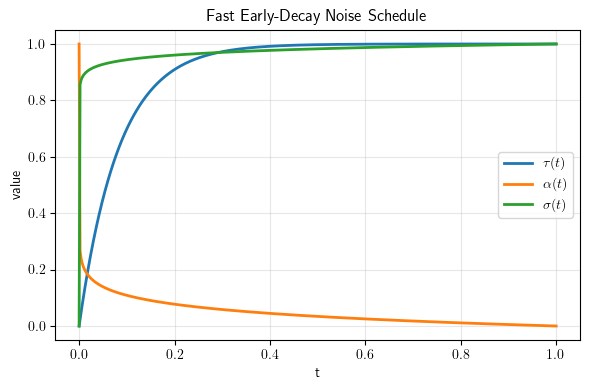

In [83]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Fast early-decay schedule
# -----------------------------
import torch

import torch

def alpha_sigma_fast(t, exponent=0.05):
    """
    Variance-preserving noise schedule that decays almost like a step at small t.
    
    Args:
        t: torch tensor of times in [0,1]
        exponent: <1 for fast decay at the start (0.1 = very fast)
    """
    # Nonlinear time warp: concave near 0
    tau_t = t ** exponent  # small t -> tau_t ~ t^0.1 ~ large (fast variance injection)
    
    # Variance-preserving linear schedule in tau
    sigma2_t = tau_t
    sigma_t = sigma2_t.sqrt()
    alpha_t = 1.0 - sigma2_t
    return alpha_t, sigma_t


# -----------------------------
# Plot
# -----------------------------
t = torch.linspace(0.0, 1.0, 500)

tau_t = tau_fast(t, beta=12.0)
alpha_t, sigma_t = alpha_sigma_fast(t)

plt.figure(figsize=(6, 4))
plt.plot(t.numpy(), tau_t.numpy(), label=r"$\tau(t)$", linewidth=2)
plt.plot(t.numpy(), alpha_t.numpy(), label=r"$\alpha(t)$", linewidth=2)
plt.plot(t.numpy(), sigma_t.numpy(), label=r"$\sigma(t)$", linewidth=2)

plt.xlabel("t")
plt.ylabel("value")
plt.title("Fast Early-Decay Noise Schedule")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# --- Compute geodesic ---
original_means = torch.tensor([
    [-1.0, -1.0],  
    [1.0, 1.0]     
], dtype=torch.float32)  
original_variance = torch.tensor(0.05, dtype=torch.float32)  # isotropic
weights = torch.tensor([0.5, 0.5], dtype=torch.float32)      # mixture weights

LAMBDA_MAX, LAMBDA_MIN = 20, -20

def tau(t, kappa=0.2, d=1.0):
    """
    Time change τ(t):
        τ(t) = 2√(κd)t                  for t ∈ [0, 1/2]
              √(κd) + (1 - √(κd))(2t-1) for t ∈ [1/2, 1]
    """
    sqrt_kd = torch.tensor(kappa, dtype=t.dtype, device=t.device)
    tau_t = torch.where(
        t <= 0.5,
        2 * sqrt_kd * t,
        sqrt_kd + (1 - sqrt_kd) * (2 * t - 1)
    )
    return tau_t


def alpha_sigma(t, T=1.0, kappa=0.9, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t).
    """
    # Apply time change
    tau_t = tau(t, kappa=kappa, d=d)

    # Base linear-in-variance schedule using τ(t) instead of t
    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t

    return alpha_t, sigma_t

def tau_fast(t, beta=12.0):
    beta_t = torch.tensor(beta, dtype=t.dtype, device=t.device)
    return (1.0 - torch.exp(-beta_t * t)) / (1.0 - torch.exp(-beta_t))


def alpha_sigma(t, beta=60.0):
    tau_t = tau_fast(t, beta=beta)
    sigma2_t = tau_t
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)
    return alpha_t, sigma_t

shortest_path12 = geodesic(torch.tensor([ 0.01, -1.0, -1.0]), torch.tensor([ 0.01, 0., 0.]),
                           n_opt_steps=100,
                           num_intermediate_points=500,
                           num_nodes=3)


# --- Compute energy ---
energy_val = energy(torch.from_numpy(shortest_path12).float().requires_grad_(True))
print('Energy of the geodesic:', energy_val.item())



100%|██████████| 100/100 [00:13<00:00,  7.18it/s]

Energy of the geodesic: 0.01359505858272314


In [ ]:
# 2D Gaussian mixture
original_means = torch.tensor([
    [-1.0, -1.0],  # first component mean
    [1.0, 1.0]     # second component mean
], dtype=torch.float32)  # shape (num_components, 2)

original_variance = torch.tensor(0.01, dtype=torch.float32)  # isotropic variance
weights = torch.tensor([0.5, 0.5], dtype=torch.float32)      # mixture weights


theta1 = torch.tensor([[0.0001, 1.0, 1.0]])  # shape (1, 3)
theta2 = torch.tensor([[0.0001, -1, -1]])  # shape (1, 3)
 # [t, x1, x2]

 
def tau(t, kappa=0.2, d=1.0):
    """
    Time change τ(t):
        τ(t) = 2√(κd)t                  for t ∈ [0, 1/2]
              √(κd) + (1 - √(κd))(2t-1) for t ∈ [1/2, 1]
    """
    sqrt_kd = torch.tensor(kappa, dtype=t.dtype, device=t.device)
    tau_t = torch.where(
        t <= 0.5,
        2 * sqrt_kd * t,
        sqrt_kd + (1 - sqrt_kd) * (2 * t - 1)
    )
    return tau_t


def alpha_sigma(t, T=1.0, kappa=0.2, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t).
    """
    # Apply time change
    tau_t = tau(t, kappa=kappa, d=d)

    # Base linear-in-variance schedule using τ(t) instead of t
    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t

    return alpha_t, sigma_t

# --- Compute geodesic ---
shortest_path12 = geodesic(theta1, theta2,
                           n_opt_steps=100,
                           num_intermediate_points=500,
                           num_nodes=3)


# --- Compute energy ---
energy_val = energy(torch.from_numpy(shortest_path12).float().requires_grad_(True))
print('Energy of the geodesic:', energy_val.item())

100%|██████████| 10/10 [00:01<00:00,  8.15it/s]

Energy of the geodesic: 1719.31005859375


In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm



def tau(t, beta=10.0):
    """
    Smooth exponential time-warp in [0,1].
    Safe for float or Tensor t.
    """
    if not torch.is_tensor(t):
        t = torch.tensor(t, dtype=torch.float32)

    beta = torch.as_tensor(beta, dtype=t.dtype, device=t.device)

    return (1.0 - torch.exp(-beta * t)) / (1.0 - torch.exp(-beta))


def alpha_sigma(t, beta=10.0):
    """
    Fast-decaying VP noise schedule.
    alpha(0)=1, alpha(1)=0
    """
    tau_t = tau(t, beta=beta)

    sigma_t = tau_t
    alpha_t = 1.0 - tau_t

    return alpha_t, sigma_t

def tau(t, kappa=0.2, d=1.0):
    """
    Time change τ(t):
        τ(t) = 2√(κd)t                  for t ∈ [0, 1/2]
              √(κd) + (1 - √(κd))(2t-1) for t ∈ [1/2, 1]
    """
    sqrt_kd = torch.tensor(kappa, dtype=t.dtype, device=t.device)
    tau_t = torch.where(
        t <= 0.5,
        2 * sqrt_kd * t,
        sqrt_kd + (1 - sqrt_kd) * (2 * t - 1)
    )
    return tau_t



LAMBDA_MAX, LAMBDA_MIN = 10, -10

def log_SNR(t):
    """Implementation of the linear-logSNR noise schedule"""
    return LAMBDA_MAX + (LAMBDA_MIN - LAMBDA_MAX) * t

def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t

def tau_fast(t, beta=12.0):
    beta_t = torch.tensor(beta, dtype=t.dtype, device=t.device)
    return (1.0 - torch.exp(-beta_t * t)) / (1.0 - torch.exp(-beta_t))


def alpha_sigma(t, beta=30.0):
    tau_t = tau_fast(t, beta=beta)
    sigma2_t = tau_t
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)
    return alpha_t, sigma_t

def alpha_sigma(t, T=1.0, kappa=0.99, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t).
    """
    # Apply time change
    tau_t = tau(t, kappa=kappa, d=d)

    # Base linear-in-variance schedule using τ(t) instead of t
    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t
    return alpha_t, sigma_t

def alpha_sigma(t, exponent=0.5):
    """
    Variance-preserving noise schedule that decays almost like a step at small t.
    
    Args:
        t: torch tensor of times in [0,1]
        exponent: <1 for fast decay at the start (0.1 = very fast)
    """
    # Nonlinear time warp: concave near 0
    tau_t = t ** exponent  # small t -> tau_t ~ t^0.1 ~ large (fast variance injection)
    
    # Variance-preserving linear schedule in tau
    sigma2_t = tau_t
    sigma_t = sigma2_t.sqrt()
    alpha_t = 1.0 - sigma2_t
    return alpha_t, sigma_t


original_means = torch.tensor([[-1.0, -1.0], [1.0, 1.0]], dtype=torch.float32)  # (K, 2)
original_variance = torch.tensor(0.05, dtype=torch.float32)  # isotropic
weights = torch.tensor([0.5, 0.5], dtype=torch.float32)

#Reference point
theta1 = torch.tensor([[0.005, 1.0, 1.0]], dtype=torch.float32)  # [t, x1, x2]
t_fixed = theta1[0, 0].item()

num_points = 35
x1_vals = np.linspace(-1.5, 1.5, num_points)
x2_vals = np.linspace(-1.5, 1.5, num_points)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
grid = np.stack([X1.ravel(), X2.ravel()], axis=1)
grid_tensor = torch.tensor(grid, dtype=torch.float32)  # shape (num_points^2, 2)

diff = grid_tensor[:, None, :] - original_means[None, :, :]  # (N, K, 2)
sq_norm = (diff**2).sum(dim=-1)  # (N, K)
var = original_variance
log_probs = -0.5 * (2 * np.log(2 * np.pi * var) + sq_norm / var)  # (N, K)
log_probs += torch.log(weights)  # add mixture weights
log_density = torch.logsumexp(log_probs, dim=1)  # (N,)
density = torch.exp(log_density).reshape(num_points, num_points)

# --- Compute geodesic distances to theta1 ---
distances = np.zeros((num_points, num_points))
for i in tqdm(range(num_points)):
    for j in range(num_points):
        theta2 = torch.tensor([[t_fixed, X1[i,j], X2[i,j]]], dtype=torch.float32)
        path = geodesic(theta1, theta2, n_opt_steps=30, num_intermediate_points=200, num_nodes=3)
        #distances[i,j] = energy(torch.from_numpy(path).float()).item()
        distances[i,j] = energy(torch.from_numpy(path).float().requires_grad_(True)).item()

        print(distances[i,j])


100%|██████████| 30/30 [00:00<00:00, 42.52it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 31.03it/s]


0.7415932416915894


100%|██████████| 30/30 [00:00<00:00, 70.74it/s]


0.7885302901268005


100%|██████████| 30/30 [00:00<00:00, 64.89it/s]


0.7787965536117554


100%|██████████| 30/30 [00:00<00:00, 67.46it/s]


0.6780492067337036


100%|██████████| 30/30 [00:00<00:00, 69.30it/s]


0.7044631242752075


100%|██████████| 30/30 [00:00<00:00, 52.25it/s]


0.6685706973075867


100%|██████████| 30/30 [00:00<00:00, 45.72it/s]


0.6369814872741699


100%|██████████| 30/30 [00:00<00:00, 49.77it/s]


0.4857619106769562


100%|██████████| 30/30 [00:00<00:00, 48.99it/s]


0.47231897711753845


100%|██████████| 30/30 [00:00<00:00, 41.01it/s]


0.467907190322876


100%|██████████| 30/30 [00:00<00:00, 39.41it/s]


0.4697352647781372


100%|██████████| 30/30 [00:00<00:00, 49.03it/s]


0.5543071031570435


100%|██████████| 30/30 [00:00<00:00, 47.69it/s]


0.6646703481674194


100%|██████████| 30/30 [00:00<00:00, 50.29it/s]


0.6490707397460938


100%|██████████| 30/30 [00:00<00:00, 41.90it/s]


0.6433689594268799


100%|██████████| 30/30 [00:00<00:00, 48.12it/s]


0.6279560327529907


100%|██████████| 30/30 [00:00<00:00, 45.72it/s]


0.6036279797554016


100%|██████████| 30/30 [00:00<00:00, 46.58it/s]


0.6164569854736328


100%|██████████| 30/30 [00:00<00:00, 47.25it/s]


0.6380271911621094


100%|██████████| 30/30 [00:00<00:00, 37.31it/s]


0.6598554253578186


100%|██████████| 30/30 [00:00<00:00, 49.95it/s]


0.6520567536354065


100%|██████████| 30/30 [00:00<00:00, 51.93it/s]


0.7037731409072876


100%|██████████| 30/30 [00:00<00:00, 47.77it/s]


0.40292689204216003


100%|██████████| 30/30 [00:00<00:00, 41.88it/s]


0.8653047680854797


100%|██████████| 30/30 [00:00<00:00, 50.22it/s]


0.8801971673965454


100%|██████████| 30/30 [00:00<00:00, 45.71it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 45.64it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 49.78it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 40.44it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 50.46it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 53.15it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 51.50it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 49.77it/s]


nan


  3%|▎         | 1/35 [00:22<12:51, 22.69s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 48.57it/s]


0.7415937185287476


100%|██████████| 30/30 [00:00<00:00, 42.50it/s]


0.8225529789924622


100%|██████████| 30/30 [00:00<00:00, 50.66it/s]


0.67996746301651


100%|██████████| 30/30 [00:00<00:00, 43.15it/s]


0.723849892616272


100%|██████████| 30/30 [00:00<00:00, 43.97it/s]


0.6891309022903442


100%|██████████| 30/30 [00:00<00:00, 46.49it/s]


0.6405248045921326


100%|██████████| 30/30 [00:00<00:00, 39.32it/s]


0.6189366579055786


100%|██████████| 30/30 [00:00<00:00, 39.97it/s]


0.5748359560966492


100%|██████████| 30/30 [00:00<00:00, 51.07it/s]


0.5131991505622864


100%|██████████| 30/30 [00:00<00:00, 42.63it/s]


0.5348405838012695


100%|██████████| 30/30 [00:00<00:00, 46.21it/s]


0.5791891813278198


100%|██████████| 30/30 [00:00<00:00, 44.29it/s]


0.6251940727233887


100%|██████████| 30/30 [00:00<00:00, 46.40it/s]


0.6404398083686829


100%|██████████| 30/30 [00:00<00:00, 47.72it/s]


0.6686595678329468


100%|██████████| 30/30 [00:00<00:00, 51.29it/s]


0.6625392436981201


100%|██████████| 30/30 [00:00<00:00, 51.05it/s]


0.6416805982589722


100%|██████████| 30/30 [00:00<00:00, 39.38it/s]


0.5985939502716064


100%|██████████| 30/30 [00:00<00:00, 47.83it/s]


0.5598287582397461


100%|██████████| 30/30 [00:00<00:00, 44.57it/s]


0.5799140334129333


100%|██████████| 30/30 [00:00<00:00, 48.84it/s]


0.6174940466880798


100%|██████████| 30/30 [00:00<00:00, 43.30it/s]


0.6519054770469666


100%|██████████| 30/30 [00:00<00:00, 50.55it/s]


0.6944126486778259


100%|██████████| 30/30 [00:00<00:00, 50.94it/s]


0.7295424938201904


100%|██████████| 30/30 [00:00<00:00, 44.50it/s]


0.7645303010940552


100%|██████████| 30/30 [00:00<00:00, 50.57it/s]


0.7776039242744446


100%|██████████| 30/30 [00:00<00:00, 39.79it/s]


0.8899943828582764


100%|██████████| 30/30 [00:00<00:00, 42.86it/s]


0.6886587738990784


100%|██████████| 30/30 [00:00<00:00, 48.75it/s]


8.83712100982666


100%|██████████| 30/30 [00:00<00:00, 51.65it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 41.85it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 48.94it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 51.29it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 49.41it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 51.84it/s]


nan


  6%|▌         | 2/35 [00:46<12:42, 23.11s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 43.23it/s]


0.7885302901268005


100%|██████████| 30/30 [00:00<00:00, 49.56it/s]


0.67996746301651


100%|██████████| 30/30 [00:00<00:00, 42.35it/s]


0.7075217962265015


100%|██████████| 30/30 [00:00<00:00, 49.21it/s]


0.6644221544265747


100%|██████████| 30/30 [00:00<00:00, 40.70it/s]


0.5872527360916138


100%|██████████| 30/30 [00:00<00:00, 51.63it/s]


0.538288950920105


100%|██████████| 30/30 [00:00<00:00, 52.17it/s]


0.5259201526641846


100%|██████████| 30/30 [00:00<00:00, 48.19it/s]


0.5128153562545776


100%|██████████| 30/30 [00:00<00:00, 40.35it/s]


0.5108047723770142


100%|██████████| 30/30 [00:00<00:00, 45.22it/s]


0.53798907995224


100%|██████████| 30/30 [00:00<00:00, 47.87it/s]


0.6017708778381348


100%|██████████| 30/30 [00:00<00:00, 51.23it/s]


0.6073485016822815


100%|██████████| 30/30 [00:00<00:00, 52.12it/s]


0.6177725195884705


100%|██████████| 30/30 [00:00<00:00, 38.62it/s]


0.631790280342102


100%|██████████| 30/30 [00:00<00:00, 51.09it/s]


0.6328965425491333


100%|██████████| 30/30 [00:00<00:00, 52.57it/s]


0.6090865731239319


100%|██████████| 30/30 [00:00<00:00, 51.31it/s]


0.5668520927429199


100%|██████████| 30/30 [00:00<00:00, 49.40it/s]


0.5207893252372742


100%|██████████| 30/30 [00:00<00:00, 37.00it/s]


0.5542306303977966


100%|██████████| 30/30 [00:00<00:00, 52.00it/s]


0.6003689765930176


100%|██████████| 30/30 [00:00<00:00, 49.28it/s]


0.6381813883781433


100%|██████████| 30/30 [00:00<00:00, 50.86it/s]


0.6833866238594055


100%|██████████| 30/30 [00:00<00:00, 52.77it/s]


0.7233301997184753


100%|██████████| 30/30 [00:00<00:00, 41.28it/s]


0.7545297741889954


100%|██████████| 30/30 [00:00<00:00, 46.44it/s]


0.7823610901832581


100%|██████████| 30/30 [00:00<00:00, 49.13it/s]


0.8200979828834534


100%|██████████| 30/30 [00:00<00:00, 46.09it/s]


0.8452925682067871


100%|██████████| 30/30 [00:00<00:00, 38.38it/s]


0.6832699179649353


100%|██████████| 30/30 [00:00<00:00, 45.38it/s]


0.5336010456085205


100%|██████████| 30/30 [00:00<00:00, 46.19it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 52.16it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 44.95it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 34.83it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 44.70it/s]


nan


  9%|▊         | 3/35 [01:09<12:24, 23.25s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 42.48it/s]


0.7787965536117554


100%|██████████| 30/30 [00:00<00:00, 40.94it/s]


0.7238476276397705


100%|██████████| 30/30 [00:00<00:00, 51.66it/s]


0.664423406124115


100%|██████████| 30/30 [00:00<00:00, 48.54it/s]


0.5795326232910156


100%|██████████| 30/30 [00:00<00:00, 52.43it/s]


0.5303198099136353


100%|██████████| 30/30 [00:00<00:00, 47.69it/s]


0.5108053088188171


100%|██████████| 30/30 [00:00<00:00, 39.72it/s]


0.5566523671150208


100%|██████████| 30/30 [00:00<00:00, 50.31it/s]


0.5486494302749634


100%|██████████| 30/30 [00:00<00:00, 48.54it/s]


0.5587735176086426


100%|██████████| 30/30 [00:00<00:00, 45.32it/s]


0.5393767952919006


100%|██████████| 30/30 [00:00<00:00, 41.00it/s]


0.5404293537139893


100%|██████████| 30/30 [00:00<00:00, 51.69it/s]


0.5475713610649109


100%|██████████| 30/30 [00:00<00:00, 43.85it/s]


0.5747585296630859


100%|██████████| 30/30 [00:00<00:00, 39.06it/s]


0.5993606448173523


100%|██████████| 30/30 [00:00<00:00, 40.98it/s]


0.5976182818412781


100%|██████████| 30/30 [00:00<00:00, 33.78it/s]


0.5706495642662048


100%|██████████| 30/30 [00:00<00:00, 37.53it/s]


0.5202717185020447


100%|██████████| 30/30 [00:00<00:00, 38.78it/s]


0.4765329658985138


100%|██████████| 30/30 [00:00<00:00, 37.56it/s]


0.5268733501434326


100%|██████████| 30/30 [00:00<00:00, 37.73it/s]


0.5764979720115662


100%|██████████| 30/30 [00:00<00:00, 40.23it/s]


0.6253589391708374


100%|██████████| 30/30 [00:00<00:00, 44.02it/s]


0.67203688621521


100%|██████████| 30/30 [00:00<00:00, 49.88it/s]


0.7158561944961548


100%|██████████| 30/30 [00:00<00:00, 38.30it/s]


0.7555587887763977


100%|██████████| 30/30 [00:00<00:00, 43.52it/s]


0.7839607000350952


100%|██████████| 30/30 [00:00<00:00, 48.87it/s]


0.8140290975570679


100%|██████████| 30/30 [00:00<00:00, 49.34it/s]


0.8365495800971985


100%|██████████| 30/30 [00:00<00:00, 47.85it/s]


0.8701301217079163


100%|██████████| 30/30 [00:00<00:00, 38.93it/s]


0.8337346315383911


100%|██████████| 30/30 [00:00<00:00, 51.39it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 47.71it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 47.65it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 47.50it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 35.17it/s]


nan


 11%|█▏        | 4/35 [01:34<12:19, 23.86s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 41.40it/s]


0.6781175136566162


100%|██████████| 30/30 [00:00<00:00, 35.36it/s]


0.6891309022903442


100%|██████████| 30/30 [00:00<00:00, 40.18it/s]


0.5872527360916138


100%|██████████| 30/30 [00:00<00:00, 47.75it/s]


0.5303197503089905


100%|██████████| 30/30 [00:00<00:00, 46.50it/s]


0.5018821358680725


100%|██████████| 30/30 [00:00<00:00, 46.44it/s]


0.47612249851226807


100%|██████████| 30/30 [00:00<00:00, 37.21it/s]


0.5148934125900269


100%|██████████| 30/30 [00:00<00:00, 43.36it/s]


0.49246665835380554


100%|██████████| 30/30 [00:00<00:00, 49.76it/s]


0.48552724719047546


100%|██████████| 30/30 [00:00<00:00, 45.78it/s]


0.47773104906082153


100%|██████████| 30/30 [00:00<00:00, 47.24it/s]


0.4885418713092804


100%|██████████| 30/30 [00:00<00:00, 39.93it/s]


0.5035232901573181


100%|██████████| 30/30 [00:00<00:00, 52.27it/s]


0.5460165739059448


100%|██████████| 30/30 [00:00<00:00, 43.52it/s]


0.5717883110046387


100%|██████████| 30/30 [00:00<00:00, 45.06it/s]


0.577045738697052


100%|██████████| 30/30 [00:00<00:00, 42.68it/s]


0.554405927658081


100%|██████████| 30/30 [00:00<00:00, 45.03it/s]


0.5009437799453735


100%|██████████| 30/30 [00:00<00:00, 47.79it/s]


0.44538387656211853


100%|██████████| 30/30 [00:00<00:00, 51.16it/s]


0.49061939120292664


100%|██████████| 30/30 [00:00<00:00, 43.36it/s]


0.5510037541389465


100%|██████████| 30/30 [00:00<00:00, 37.15it/s]


0.607715368270874


100%|██████████| 30/30 [00:00<00:00, 49.19it/s]


0.6556040048599243


100%|██████████| 30/30 [00:00<00:00, 41.64it/s]


0.7031153440475464


100%|██████████| 30/30 [00:00<00:00, 48.52it/s]


0.7458322048187256


100%|██████████| 30/30 [00:00<00:00, 45.38it/s]


0.7852146625518799


100%|██████████| 30/30 [00:00<00:00, 43.31it/s]


0.8114009499549866


100%|██████████| 30/30 [00:00<00:00, 51.52it/s]


0.8393543362617493


100%|██████████| 30/30 [00:00<00:00, 46.92it/s]


0.851768970489502


100%|██████████| 30/30 [00:00<00:00, 45.90it/s]


0.8872811794281006


100%|██████████| 30/30 [00:00<00:00, 40.92it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 47.17it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 43.63it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 46.33it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 51.08it/s]


nan


 14%|█▍        | 5/35 [01:58<12:00, 24.02s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 48.40it/s]


0.7044652700424194


100%|██████████| 30/30 [00:00<00:00, 48.58it/s]


0.6405248045921326


100%|██████████| 30/30 [00:00<00:00, 49.82it/s]


0.5382041335105896


100%|██████████| 30/30 [00:00<00:00, 40.12it/s]


0.5108928680419922


100%|██████████| 30/30 [00:00<00:00, 43.15it/s]


0.47612449526786804


100%|██████████| 30/30 [00:00<00:00, 47.11it/s]


0.45928242802619934


100%|██████████| 30/30 [00:00<00:00, 47.51it/s]


0.42123425006866455


100%|██████████| 30/30 [00:00<00:00, 47.95it/s]


0.3750380277633667


100%|██████████| 30/30 [00:00<00:00, 40.60it/s]


0.37765076756477356


100%|██████████| 30/30 [00:00<00:00, 46.23it/s]


0.3885784149169922


100%|██████████| 30/30 [00:00<00:00, 51.96it/s]


0.439336895942688


100%|██████████| 30/30 [00:00<00:00, 51.27it/s]


0.4844602346420288


100%|██████████| 30/30 [00:00<00:00, 37.98it/s]


0.5153099298477173


100%|██████████| 30/30 [00:00<00:00, 46.28it/s]


0.5320836305618286


100%|██████████| 30/30 [00:00<00:00, 52.76it/s]


0.5526576042175293


100%|██████████| 30/30 [00:00<00:00, 49.19it/s]


0.5481281876564026


100%|██████████| 30/30 [00:00<00:00, 50.83it/s]


0.5155271887779236


100%|██████████| 30/30 [00:00<00:00, 40.77it/s]


0.4458882212638855


100%|██████████| 30/30 [00:00<00:00, 51.23it/s]


0.47705113887786865


100%|██████████| 30/30 [00:00<00:00, 46.38it/s]


0.5377722382545471


100%|██████████| 30/30 [00:00<00:00, 51.20it/s]


0.5941027402877808


100%|██████████| 30/30 [00:00<00:00, 39.42it/s]


0.646942675113678


100%|██████████| 30/30 [00:00<00:00, 39.64it/s]


0.6949653625488281


100%|██████████| 30/30 [00:00<00:00, 49.62it/s]


0.7388948798179626


100%|██████████| 30/30 [00:00<00:00, 51.88it/s]


0.7797420620918274


100%|██████████| 30/30 [00:00<00:00, 48.47it/s]


0.8150250315666199


100%|██████████| 30/30 [00:00<00:00, 39.33it/s]


0.8392617702484131


100%|██████████| 30/30 [00:00<00:00, 51.91it/s]


0.8559247255325317


100%|██████████| 30/30 [00:00<00:00, 48.73it/s]


0.8657309412956238


100%|██████████| 30/30 [00:00<00:00, 52.23it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 37.65it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 45.53it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 49.98it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 48.26it/s]


nan


 17%|█▋        | 6/35 [02:21<11:28, 23.74s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 40.62it/s]


0.6685705184936523


100%|██████████| 30/30 [00:00<00:00, 50.77it/s]


0.6189366579055786


100%|██████████| 30/30 [00:00<00:00, 50.29it/s]


0.5259201526641846


100%|██████████| 30/30 [00:00<00:00, 45.36it/s]


0.5566523671150208


100%|██████████| 30/30 [00:00<00:00, 44.48it/s]


0.5148902535438538


100%|██████████| 30/30 [00:00<00:00, 39.30it/s]


0.42123425006866455


100%|██████████| 30/30 [00:00<00:00, 46.79it/s]


0.30187714099884033


100%|██████████| 30/30 [00:00<00:00, 50.82it/s]


0.2597197890281677


100%|██████████| 30/30 [00:00<00:00, 51.34it/s]


0.2909852862358093


100%|██████████| 30/30 [00:00<00:00, 36.88it/s]


0.3395179808139801


100%|██████████| 30/30 [00:00<00:00, 49.26it/s]


0.39487147331237793


100%|██████████| 30/30 [00:00<00:00, 50.73it/s]


0.4658242464065552


100%|██████████| 30/30 [00:00<00:00, 39.70it/s]


0.5044736862182617


100%|██████████| 30/30 [00:00<00:00, 38.69it/s]


0.5094548463821411


100%|██████████| 30/30 [00:00<00:00, 49.33it/s]


0.5540041327476501


100%|██████████| 30/30 [00:00<00:00, 47.67it/s]


0.5546919703483582


100%|██████████| 30/30 [00:00<00:00, 49.98it/s]


0.5356106162071228


100%|██████████| 30/30 [00:00<00:00, 42.50it/s]


0.4783673584461212


100%|██████████| 30/30 [00:00<00:00, 50.29it/s]


0.4921153485774994


100%|██████████| 30/30 [00:00<00:00, 47.16it/s]


0.534265398979187


100%|██████████| 30/30 [00:00<00:00, 47.99it/s]


0.5822120308876038


100%|██████████| 30/30 [00:00<00:00, 38.68it/s]


0.6324901580810547


100%|██████████| 30/30 [00:00<00:00, 46.60it/s]


0.6803829073905945


100%|██████████| 30/30 [00:00<00:00, 49.88it/s]


0.7271594405174255


100%|██████████| 30/30 [00:00<00:00, 49.17it/s]


0.7654805183410645


100%|██████████| 30/30 [00:00<00:00, 46.80it/s]


0.8042304515838623


100%|██████████| 30/30 [00:00<00:00, 36.73it/s]


0.8365370035171509


100%|██████████| 30/30 [00:00<00:00, 49.45it/s]


0.8529161214828491


100%|██████████| 30/30 [00:00<00:00, 47.22it/s]


0.8716220259666443


100%|██████████| 30/30 [00:00<00:00, 45.10it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 38.52it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 36.96it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 48.93it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 50.32it/s]


nan


 20%|██        | 7/35 [02:45<11:06, 23.81s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 43.82it/s]


0.6369792819023132


100%|██████████| 30/30 [00:00<00:00, 48.80it/s]


0.5748359560966492


100%|██████████| 30/30 [00:00<00:00, 39.04it/s]


0.5128153562545776


100%|██████████| 30/30 [00:00<00:00, 46.41it/s]


0.5486497282981873


100%|██████████| 30/30 [00:00<00:00, 39.69it/s]


0.49246665835380554


100%|██████████| 30/30 [00:00<00:00, 47.33it/s]


0.3750380277633667


100%|██████████| 30/30 [00:00<00:00, 53.12it/s]


0.2597179412841797


100%|██████████| 30/30 [00:00<00:00, 52.11it/s]


0.15857793390750885


100%|██████████| 30/30 [00:00<00:00, 49.81it/s]


0.2650500535964966


100%|██████████| 30/30 [00:00<00:00, 40.85it/s]


0.34538882970809937


100%|██████████| 30/30 [00:00<00:00, 52.07it/s]


0.44207772612571716


100%|██████████| 30/30 [00:00<00:00, 44.81it/s]


0.48572516441345215


100%|██████████| 30/30 [00:00<00:00, 46.07it/s]


0.510909914970398


100%|██████████| 30/30 [00:00<00:00, 51.32it/s]


0.6191539168357849


100%|██████████| 30/30 [00:00<00:00, 42.81it/s]


0.40234506130218506


100%|██████████| 30/30 [00:00<00:00, 48.46it/s]


0.5718259811401367


100%|██████████| 30/30 [00:00<00:00, 53.31it/s]


0.5685746073722839


100%|██████████| 30/30 [00:00<00:00, 52.61it/s]


0.5314079523086548


100%|██████████| 30/30 [00:00<00:00, 48.71it/s]


0.5324059724807739


100%|██████████| 30/30 [00:00<00:00, 39.66it/s]


0.544608473777771


100%|██████████| 30/30 [00:00<00:00, 47.80it/s]


0.5801090002059937


100%|██████████| 30/30 [00:00<00:00, 47.53it/s]


0.6189783811569214


100%|██████████| 30/30 [00:00<00:00, 48.98it/s]


0.6626325249671936


100%|██████████| 30/30 [00:00<00:00, 54.03it/s]


0.7075088024139404


100%|██████████| 30/30 [00:00<00:00, 41.92it/s]


0.7502550482749939


100%|██████████| 30/30 [00:00<00:00, 47.67it/s]


0.7877434492111206


100%|██████████| 30/30 [00:00<00:00, 50.03it/s]


0.8202450275421143


100%|██████████| 30/30 [00:00<00:00, 50.33it/s]


0.8426499366760254


100%|██████████| 30/30 [00:00<00:00, 46.67it/s]


0.8616659641265869


100%|██████████| 30/30 [00:00<00:00, 39.36it/s]


0.9118345975875854


100%|██████████| 30/30 [00:00<00:00, 51.30it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 49.82it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 52.27it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 52.79it/s]


nan


 23%|██▎       | 8/35 [03:08<10:35, 23.52s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 48.84it/s]


0.48575541377067566


100%|██████████| 30/30 [00:00<00:00, 52.59it/s]


0.5132010579109192


100%|██████████| 30/30 [00:00<00:00, 51.28it/s]


0.5108047723770142


100%|██████████| 30/30 [00:00<00:00, 43.25it/s]


0.5587735176086426


100%|██████████| 30/30 [00:00<00:00, 40.44it/s]


0.4855257272720337


100%|██████████| 30/30 [00:00<00:00, 51.90it/s]


0.3776516318321228


100%|██████████| 30/30 [00:00<00:00, 49.88it/s]


0.2909839153289795


100%|██████████| 30/30 [00:00<00:00, 51.98it/s]


0.2650500535964966


100%|██████████| 30/30 [00:00<00:00, 51.61it/s]


0.354471892118454


100%|██████████| 30/30 [00:00<00:00, 38.71it/s]


0.4493134319782257


100%|██████████| 30/30 [00:00<00:00, 50.28it/s]


0.4771897792816162


100%|██████████| 30/30 [00:00<00:00, 49.83it/s]


0.36531585454940796


100%|██████████| 30/30 [00:00<00:00, 48.99it/s]


0.580948531627655


100%|██████████| 30/30 [00:00<00:00, 40.41it/s]


0.3671797513961792


100%|██████████| 30/30 [00:00<00:00, 50.70it/s]


0.3318837285041809


100%|██████████| 30/30 [00:00<00:00, 51.69it/s]


0.6888324618339539


100%|██████████| 30/30 [00:00<00:00, 49.32it/s]


0.5928683280944824


100%|██████████| 30/30 [00:00<00:00, 52.16it/s]


0.5834547281265259


100%|██████████| 30/30 [00:00<00:00, 51.69it/s]


0.5760489702224731


100%|██████████| 30/30 [00:00<00:00, 47.19it/s]


0.5631778240203857


100%|██████████| 30/30 [00:00<00:00, 47.91it/s]


0.5784947276115417


100%|██████████| 30/30 [00:00<00:00, 50.13it/s]


0.6079778075218201


100%|██████████| 30/30 [00:00<00:00, 52.05it/s]


0.6440826058387756


100%|██████████| 30/30 [00:00<00:00, 48.56it/s]


0.6875534057617188


100%|██████████| 30/30 [00:00<00:00, 39.82it/s]


0.7303973436355591


100%|██████████| 30/30 [00:00<00:00, 51.95it/s]


0.7671648859977722


100%|██████████| 30/30 [00:00<00:00, 48.56it/s]


0.8016093969345093


100%|██████████| 30/30 [00:00<00:00, 50.75it/s]


0.8316890597343445


100%|██████████| 30/30 [00:00<00:00, 51.30it/s]


0.8492524027824402


100%|██████████| 30/30 [00:00<00:00, 36.35it/s]


0.34806114435195923


100%|██████████| 30/30 [00:00<00:00, 48.86it/s]


0.9739804863929749


100%|██████████| 30/30 [00:00<00:00, 46.21it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 51.11it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 52.10it/s]


nan


 26%|██▌       | 9/35 [03:31<10:04, 23.24s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 52.20it/s]


0.47231897711753845


100%|██████████| 30/30 [00:00<00:00, 48.20it/s]


0.5348416566848755


100%|██████████| 30/30 [00:00<00:00, 50.87it/s]


0.53798907995224


100%|██████████| 30/30 [00:00<00:00, 48.59it/s]


0.5393767952919006


100%|██████████| 30/30 [00:00<00:00, 36.54it/s]


0.4777320623397827


100%|██████████| 30/30 [00:00<00:00, 50.59it/s]


0.3885784149169922


100%|██████████| 30/30 [00:00<00:00, 49.39it/s]


0.3395153880119324


100%|██████████| 30/30 [00:00<00:00, 48.76it/s]


0.34538882970809937


100%|██████████| 30/30 [00:00<00:00, 52.58it/s]


0.4493134319782257


100%|██████████| 30/30 [00:00<00:00, 41.49it/s]


0.47775155305862427


100%|██████████| 30/30 [00:00<00:00, 50.56it/s]


0.5643087029457092


100%|██████████| 30/30 [00:00<00:00, 49.38it/s]


0.5652561783790588


100%|██████████| 30/30 [00:00<00:00, 45.99it/s]


0.35204237699508667


100%|██████████| 30/30 [00:00<00:00, 32.82it/s]


0.36630773544311523


100%|██████████| 30/30 [00:00<00:00, 48.99it/s]


0.3281792104244232


100%|██████████| 30/30 [00:00<00:00, 51.63it/s]


0.7380011677742004


100%|██████████| 30/30 [00:00<00:00, 53.09it/s]


0.6211458444595337


100%|██████████| 30/30 [00:00<00:00, 46.47it/s]


0.6228269338607788


100%|██████████| 30/30 [00:00<00:00, 51.50it/s]


0.6084977984428406


100%|██████████| 30/30 [00:00<00:00, 40.83it/s]


0.5820510387420654


100%|██████████| 30/30 [00:01<00:00, 15.18it/s]


0.5744503736495972


100%|██████████| 30/30 [00:00<00:00, 49.16it/s]


0.5927034616470337


100%|██████████| 30/30 [00:01<00:00, 23.88it/s]


0.6210986971855164


100%|██████████| 30/30 [00:00<00:00, 40.67it/s]


0.6647618412971497


100%|██████████| 30/30 [00:00<00:00, 52.57it/s]


0.7070605754852295


100%|██████████| 30/30 [00:00<00:00, 52.25it/s]


0.7454514503479004


100%|██████████| 30/30 [00:00<00:00, 50.24it/s]


0.7796412706375122


100%|██████████| 30/30 [00:00<00:00, 36.01it/s]


0.8120198249816895


100%|██████████| 30/30 [00:00<00:00, 40.39it/s]


0.8347599506378174


100%|██████████| 30/30 [00:00<00:00, 47.84it/s]


0.8217231631278992


100%|██████████| 30/30 [00:00<00:00, 49.49it/s]


0.9126313328742981


100%|██████████| 30/30 [00:00<00:00, 40.19it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 49.46it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 50.66it/s]


nan


 29%|██▊       | 10/35 [03:56<09:55, 23.82s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 43.09it/s]


0.467907190322876


100%|██████████| 30/30 [00:00<00:00, 40.84it/s]


0.5791891813278198


100%|██████████| 30/30 [00:00<00:00, 49.58it/s]


0.6017708778381348


100%|██████████| 30/30 [00:00<00:00, 50.75it/s]


0.5404293537139893


100%|██████████| 30/30 [00:00<00:00, 51.46it/s]


0.48854339122772217


100%|██████████| 30/30 [00:00<00:00, 48.33it/s]


0.439336895942688


100%|██████████| 30/30 [00:00<00:00, 42.35it/s]


0.3948761820793152


100%|██████████| 30/30 [00:00<00:00, 49.88it/s]


0.44207772612571716


100%|██████████| 30/30 [00:00<00:00, 33.35it/s]


0.4771897792816162


100%|██████████| 30/30 [00:00<00:00, 30.74it/s]


0.5643087029457092


100%|██████████| 30/30 [00:00<00:00, 36.92it/s]


0.6708851456642151


100%|██████████| 30/30 [00:00<00:00, 43.65it/s]


0.3721030056476593


100%|██████████| 30/30 [00:00<00:00, 48.32it/s]


0.7753294110298157


100%|██████████| 30/30 [00:00<00:00, 49.30it/s]


0.7793413400650024


100%|██████████| 30/30 [00:00<00:00, 47.37it/s]


0.34611064195632935


100%|██████████| 30/30 [00:00<00:00, 42.56it/s]


0.7618052363395691


100%|██████████| 30/30 [00:00<00:00, 48.03it/s]


0.7083788514137268


100%|██████████| 30/30 [00:00<00:00, 44.33it/s]


0.6452811360359192


100%|██████████| 30/30 [00:00<00:00, 48.78it/s]


0.6562713384628296


100%|██████████| 30/30 [00:00<00:00, 51.29it/s]


0.5905100703239441


100%|██████████| 30/30 [00:00<00:00, 40.33it/s]


0.5629829168319702


100%|██████████| 30/30 [00:00<00:00, 49.99it/s]


0.5703184604644775


100%|██████████| 30/30 [00:00<00:00, 49.48it/s]


0.5973900556564331


100%|██████████| 30/30 [00:00<00:00, 53.28it/s]


0.6394221782684326


100%|██████████| 30/30 [00:00<00:00, 50.52it/s]


0.6829888820648193


100%|██████████| 30/30 [00:00<00:00, 39.46it/s]


0.7216377854347229


100%|██████████| 30/30 [00:00<00:00, 46.00it/s]


0.7558780908584595


100%|██████████| 30/30 [00:00<00:00, 45.40it/s]


0.7880074977874756


100%|██████████| 30/30 [00:00<00:00, 52.12it/s]


0.8143389225006104


100%|██████████| 30/30 [00:00<00:00, 52.21it/s]


0.802689790725708


100%|██████████| 30/30 [00:00<00:00, 41.42it/s]


0.8630909323692322


100%|██████████| 30/30 [00:00<00:00, 50.72it/s]


0.9217479228973389


100%|██████████| 30/30 [00:00<00:00, 51.14it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 47.33it/s]


nan


 31%|███▏      | 11/35 [04:20<09:30, 23.78s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 38.25it/s]


0.4697352647781372


100%|██████████| 30/30 [00:00<00:00, 48.37it/s]


0.6251940727233887


100%|██████████| 30/30 [00:00<00:00, 45.51it/s]


0.6073486804962158


100%|██████████| 30/30 [00:00<00:00, 50.93it/s]


0.5475736260414124


100%|██████████| 30/30 [00:00<00:00, 40.80it/s]


0.5035232901573181


100%|██████████| 30/30 [00:00<00:00, 47.95it/s]


0.4844605028629303


100%|██████████| 30/30 [00:00<00:00, 49.54it/s]


0.4658242464065552


100%|██████████| 30/30 [00:00<00:00, 52.61it/s]


0.4857299327850342


100%|██████████| 30/30 [00:00<00:00, 45.43it/s]


0.3653136193752289


100%|██████████| 30/30 [00:00<00:00, 39.20it/s]


0.5652561783790588


100%|██████████| 30/30 [00:00<00:00, 51.53it/s]


0.3721030056476593


100%|██████████| 30/30 [00:00<00:00, 46.96it/s]


0.8396139144897461


100%|██████████| 30/30 [00:00<00:00, 51.58it/s]


0.8673478960990906


100%|██████████| 30/30 [00:00<00:00, 51.67it/s]


0.8572802543640137


100%|██████████| 30/30 [00:00<00:00, 41.09it/s]


0.8087168335914612


100%|██████████| 30/30 [00:00<00:00, 50.57it/s]


0.4507748782634735


100%|██████████| 30/30 [00:00<00:00, 50.82it/s]


0.7119423151016235


100%|██████████| 30/30 [00:00<00:00, 47.91it/s]


0.6742476224899292


100%|██████████| 30/30 [00:00<00:00, 44.40it/s]


0.6678926944732666


100%|██████████| 30/30 [00:00<00:00, 51.37it/s]


0.5855342149734497


100%|██████████| 30/30 [00:00<00:00, 41.76it/s]


0.5407954454421997


100%|██████████| 30/30 [00:00<00:00, 47.80it/s]


0.5442561507225037


100%|██████████| 30/30 [00:00<00:00, 49.91it/s]


0.576618492603302


100%|██████████| 30/30 [00:00<00:00, 48.82it/s]


0.6224901080131531


100%|██████████| 30/30 [00:00<00:00, 51.18it/s]


0.6628739237785339


100%|██████████| 30/30 [00:00<00:00, 42.84it/s]


0.7016054391860962


100%|██████████| 30/30 [00:00<00:00, 46.97it/s]


0.7379574775695801


100%|██████████| 30/30 [00:00<00:00, 41.11it/s]


0.7690089344978333


100%|██████████| 30/30 [00:00<00:00, 42.78it/s]


0.8005797863006592


100%|██████████| 30/30 [00:00<00:00, 40.35it/s]


0.7862862348556519


100%|██████████| 30/30 [00:00<00:00, 49.11it/s]


0.8450714945793152


100%|██████████| 30/30 [00:00<00:00, 47.66it/s]


0.9251053929328918


100%|██████████| 30/30 [00:00<00:00, 52.06it/s]


1.1426317691802979


100%|██████████| 30/30 [00:00<00:00, 48.91it/s]


nan


 34%|███▍      | 12/35 [04:43<09:03, 23.63s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 46.01it/s]


0.5543071031570435


100%|██████████| 30/30 [00:00<00:00, 50.59it/s]


0.6404387354850769


100%|██████████| 30/30 [00:00<00:00, 47.80it/s]


0.6177725195884705


100%|██████████| 30/30 [00:00<00:00, 51.43it/s]


0.5747585296630859


100%|██████████| 30/30 [00:00<00:00, 42.01it/s]


0.5460165739059448


100%|██████████| 30/30 [00:00<00:00, 46.79it/s]


0.5153099298477173


100%|██████████| 30/30 [00:00<00:00, 47.12it/s]


0.5044711828231812


100%|██████████| 30/30 [00:00<00:00, 49.82it/s]


0.510909914970398


100%|██████████| 30/30 [00:00<00:00, 38.87it/s]


0.580948531627655


100%|██████████| 30/30 [00:00<00:00, 46.00it/s]


0.35204237699508667


100%|██████████| 30/30 [00:00<00:00, 51.56it/s]


0.7753294110298157


100%|██████████| 30/30 [00:00<00:00, 49.19it/s]


0.8673478960990906


100%|██████████| 30/30 [00:00<00:00, 38.89it/s]


0.880129873752594


100%|██████████| 30/30 [00:00<00:00, 41.83it/s]


0.8699513077735901


100%|██████████| 30/30 [00:00<00:00, 50.63it/s]


0.8171778321266174


100%|██████████| 30/30 [00:00<00:00, 50.84it/s]


0.35021641850471497


100%|██████████| 30/30 [00:00<00:00, 48.65it/s]


0.7133755087852478


100%|██████████| 30/30 [00:00<00:00, 43.93it/s]


0.661517858505249


100%|██████████| 30/30 [00:00<00:00, 37.37it/s]


0.6642919182777405


100%|██████████| 30/30 [00:00<00:00, 52.83it/s]


0.5638347864151001


100%|██████████| 30/30 [00:00<00:00, 53.19it/s]


0.5134142637252808


100%|██████████| 30/30 [00:00<00:00, 46.16it/s]


0.5205561518669128


100%|██████████| 30/30 [00:00<00:00, 40.78it/s]


0.5620534420013428


100%|██████████| 30/30 [00:00<00:00, 50.56it/s]


0.6107096076011658


100%|██████████| 30/30 [00:00<00:00, 47.36it/s]


0.6511500477790833


100%|██████████| 30/30 [00:00<00:00, 50.56it/s]


0.6831510663032532


100%|██████████| 30/30 [00:00<00:00, 46.95it/s]


0.7219991087913513


100%|██████████| 30/30 [00:00<00:00, 37.99it/s]


0.7558615207672119


100%|██████████| 30/30 [00:00<00:00, 51.47it/s]


0.7865726351737976


100%|██████████| 30/30 [00:00<00:00, 37.81it/s]


0.7744194269180298


100%|██████████| 30/30 [00:00<00:00, 46.86it/s]


0.8355408310890198


100%|██████████| 30/30 [00:00<00:00, 48.84it/s]


0.8965811133384705


100%|██████████| 30/30 [00:00<00:00, 42.70it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 46.12it/s]


nan


 37%|███▋      | 13/35 [05:06<08:38, 23.57s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 47.45it/s]


0.6646703481674194


100%|██████████| 30/30 [00:00<00:00, 38.30it/s]


0.6686595678329468


100%|██████████| 30/30 [00:00<00:00, 51.26it/s]


0.6317886114120483


100%|██████████| 30/30 [00:00<00:00, 44.14it/s]


0.5993606448173523


100%|██████████| 30/30 [00:00<00:00, 47.89it/s]


0.5717883706092834


100%|██████████| 30/30 [00:00<00:00, 50.85it/s]


0.5320836305618286


100%|██████████| 30/30 [00:00<00:00, 45.34it/s]


0.5094554424285889


100%|██████████| 30/30 [00:00<00:00, 48.82it/s]


0.6191539168357849


100%|██████████| 30/30 [00:00<00:00, 45.54it/s]


0.3671797513961792


100%|██████████| 30/30 [00:00<00:00, 50.22it/s]


0.36630773544311523


100%|██████████| 30/30 [00:00<00:00, 52.37it/s]


0.7793413400650024


100%|██████████| 30/30 [00:00<00:00, 39.50it/s]


0.8572802543640137


100%|██████████| 30/30 [00:00<00:00, 49.72it/s]


0.8699513077735901


100%|██████████| 30/30 [00:00<00:00, 51.46it/s]


0.8547447323799133


100%|██████████| 30/30 [00:00<00:00, 46.83it/s]


0.7943174242973328


100%|██████████| 30/30 [00:00<00:00, 52.77it/s]


0.30767911672592163


100%|██████████| 30/30 [00:00<00:00, 40.79it/s]


0.6909529566764832


100%|██████████| 30/30 [00:00<00:00, 42.80it/s]


0.6722325682640076


100%|██████████| 30/30 [00:00<00:00, 47.55it/s]


0.676971435546875


100%|██████████| 30/30 [00:00<00:00, 50.27it/s]


0.5029047131538391


100%|██████████| 30/30 [00:00<00:00, 51.33it/s]


0.47994935512542725


100%|██████████| 30/30 [00:00<00:00, 40.69it/s]


0.5005873441696167


100%|██████████| 30/30 [00:00<00:00, 51.28it/s]


0.548622727394104


100%|██████████| 30/30 [00:00<00:00, 51.29it/s]


0.596561074256897


100%|██████████| 30/30 [00:00<00:00, 48.41it/s]


0.639743447303772


100%|██████████| 30/30 [00:00<00:00, 50.51it/s]


0.6696808338165283


100%|██████████| 30/30 [00:00<00:00, 38.36it/s]


0.7097510099411011


100%|██████████| 30/30 [00:00<00:00, 48.43it/s]


0.7474064230918884


100%|██████████| 30/30 [00:00<00:00, 51.52it/s]


0.7820895314216614


100%|██████████| 30/30 [00:00<00:00, 50.64it/s]


0.7736733555793762


100%|██████████| 30/30 [00:00<00:00, 51.89it/s]


0.8318091630935669


100%|██████████| 30/30 [00:00<00:00, 39.74it/s]


0.8891404271125793


100%|██████████| 30/30 [00:00<00:00, 50.91it/s]


0.976413369178772


100%|██████████| 30/30 [00:00<00:00, 52.36it/s]


1.4970922470092773


 40%|████      | 14/35 [05:29<08:10, 23.36s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 46.38it/s]


0.6490707397460938


100%|██████████| 30/30 [00:00<00:00, 41.12it/s]


0.6625421047210693


100%|██████████| 30/30 [00:00<00:00, 47.85it/s]


0.6328965425491333


100%|██████████| 30/30 [00:00<00:00, 50.83it/s]


0.5976182818412781


100%|██████████| 30/30 [00:00<00:00, 52.19it/s]


0.577045738697052


100%|██████████| 30/30 [00:00<00:00, 51.25it/s]


0.5526576042175293


100%|██████████| 30/30 [00:00<00:00, 39.33it/s]


0.5540010333061218


100%|██████████| 30/30 [00:00<00:00, 52.12it/s]


0.40234506130218506


100%|██████████| 30/30 [00:00<00:00, 48.06it/s]


0.3318832516670227


100%|██████████| 30/30 [00:00<00:00, 42.23it/s]


0.3281792104244232


100%|██████████| 30/30 [00:00<00:00, 42.42it/s]


0.3459545969963074


100%|██████████| 30/30 [00:00<00:00, 50.84it/s]


0.8087199926376343


100%|██████████| 30/30 [00:00<00:00, 48.93it/s]


0.8171823024749756


100%|██████████| 30/30 [00:00<00:00, 51.91it/s]


0.7943174242973328


100%|██████████| 30/30 [00:00<00:00, 39.66it/s]


0.7407152056694031


100%|██████████| 30/30 [00:00<00:00, 46.46it/s]


0.8045467734336853


100%|██████████| 30/30 [00:00<00:00, 53.21it/s]


0.6531519889831543


100%|██████████| 30/30 [00:00<00:00, 46.81it/s]


0.5757864117622375


100%|██████████| 30/30 [00:00<00:00, 48.52it/s]


0.5637383460998535


100%|██████████| 30/30 [00:00<00:00, 40.72it/s]


0.4483512043952942


100%|██████████| 30/30 [00:00<00:00, 51.44it/s]


0.4433598220348358


100%|██████████| 30/30 [00:00<00:00, 50.87it/s]


0.48172205686569214


100%|██████████| 30/30 [00:00<00:00, 49.20it/s]


0.5312443375587463


100%|██████████| 30/30 [00:00<00:00, 52.73it/s]


0.5797008275985718


100%|██████████| 30/30 [00:00<00:00, 41.18it/s]


0.6246313452720642


100%|██████████| 30/30 [00:00<00:00, 43.20it/s]


0.6593997478485107


100%|██████████| 30/30 [00:00<00:00, 46.16it/s]


0.7049829959869385


100%|██████████| 30/30 [00:00<00:00, 48.22it/s]


0.7510331273078918


100%|██████████| 30/30 [00:00<00:00, 47.02it/s]


0.7900082468986511


100%|██████████| 30/30 [00:00<00:00, 43.29it/s]


0.780727207660675


100%|██████████| 30/30 [00:00<00:00, 53.26it/s]


0.8331344127655029


100%|██████████| 30/30 [00:00<00:00, 48.19it/s]


0.8872345685958862


100%|██████████| 30/30 [00:00<00:00, 50.62it/s]


0.9369734525680542


100%|██████████| 30/30 [00:00<00:00, 48.06it/s]


1.4749088287353516


 43%|████▎     | 15/35 [05:52<07:45, 23.27s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 47.84it/s]


0.6433719396591187


100%|██████████| 30/30 [00:00<00:00, 49.72it/s]


0.6416805982589722


100%|██████████| 30/30 [00:00<00:00, 50.07it/s]


0.6090829968452454


100%|██████████| 30/30 [00:00<00:00, 47.77it/s]


0.5706495642662048


100%|██████████| 30/30 [00:00<00:00, 41.77it/s]


0.554405927658081


100%|██████████| 30/30 [00:00<00:00, 49.97it/s]


0.548126757144928


100%|██████████| 30/30 [00:00<00:00, 49.13it/s]


0.5547063946723938


100%|██████████| 30/30 [00:00<00:00, 52.48it/s]


0.571824848651886


100%|██████████| 30/30 [00:00<00:00, 48.31it/s]


0.6888337135314941


100%|██████████| 30/30 [00:00<00:00, 36.16it/s]


0.7380011677742004


100%|██████████| 30/30 [00:00<00:00, 51.46it/s]


0.7618100643157959


100%|██████████| 30/30 [00:00<00:00, 50.58it/s]


0.4507461190223694


100%|██████████| 30/30 [00:00<00:00, 49.93it/s]


0.35021641850471497


100%|██████████| 30/30 [00:00<00:00, 51.36it/s]


0.3077261447906494


100%|██████████| 30/30 [00:00<00:00, 43.15it/s]


0.8045485019683838


100%|██████████| 30/30 [00:00<00:00, 49.91it/s]


0.6611014008522034


100%|██████████| 30/30 [00:00<00:00, 49.21it/s]


0.6032072305679321


100%|██████████| 30/30 [00:00<00:00, 46.26it/s]


0.6384463906288147


100%|██████████| 30/30 [00:00<00:00, 36.20it/s]


0.42643365263938904


100%|██████████| 30/30 [00:00<00:00, 47.06it/s]


0.39840659499168396


100%|██████████| 30/30 [00:00<00:00, 48.95it/s]


0.41899529099464417


100%|██████████| 30/30 [00:00<00:00, 45.36it/s]


0.4657670557498932


100%|██████████| 30/30 [00:00<00:00, 43.54it/s]


0.5160678625106812


100%|██████████| 30/30 [00:00<00:00, 40.45it/s]


0.5659962892532349


100%|██████████| 30/30 [00:00<00:00, 50.51it/s]


0.6138428449630737


100%|██████████| 30/30 [00:00<00:00, 46.59it/s]


0.6557657122612


100%|██████████| 30/30 [00:00<00:00, 46.51it/s]


0.7099355459213257


100%|██████████| 30/30 [00:00<00:00, 40.07it/s]


0.7578476667404175


100%|██████████| 30/30 [00:00<00:00, 46.37it/s]


0.7990375757217407


100%|██████████| 30/30 [00:00<00:00, 50.60it/s]


0.7875988483428955


100%|██████████| 30/30 [00:00<00:00, 50.96it/s]


0.836807131767273


100%|██████████| 30/30 [00:00<00:00, 46.96it/s]


0.8847604393959045


100%|██████████| 30/30 [00:00<00:00, 48.25it/s]


0.9340070486068726


100%|██████████| 30/30 [00:00<00:00, 50.34it/s]


1.069440245628357


 46%|████▌     | 16/35 [06:15<07:21, 23.25s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 47.91it/s]


0.6279579401016235


100%|██████████| 30/30 [00:00<00:00, 42.26it/s]


0.5985927581787109


100%|██████████| 30/30 [00:00<00:00, 49.86it/s]


0.5668520927429199


100%|██████████| 30/30 [00:00<00:00, 49.07it/s]


0.5202717185020447


100%|██████████| 30/30 [00:00<00:00, 49.66it/s]


0.5009433031082153


100%|██████████| 30/30 [00:00<00:00, 49.24it/s]


0.5155284404754639


100%|██████████| 30/30 [00:00<00:00, 38.93it/s]


0.5356088280677795


100%|██████████| 30/30 [00:00<00:00, 52.53it/s]


0.5685699582099915


100%|██████████| 30/30 [00:00<00:00, 46.25it/s]


0.5928683280944824


100%|██████████| 30/30 [00:00<00:00, 44.48it/s]


0.6211458444595337


100%|██████████| 30/30 [00:00<00:00, 41.36it/s]


0.7083788514137268


100%|██████████| 30/30 [00:00<00:00, 49.17it/s]


0.7119446992874146


100%|██████████| 30/30 [00:00<00:00, 47.38it/s]


0.7133731842041016


100%|██████████| 30/30 [00:00<00:00, 50.70it/s]


0.6909529566764832


100%|██████████| 30/30 [00:00<00:00, 52.51it/s]


0.6531519889831543


100%|██████████| 30/30 [00:00<00:00, 39.58it/s]


0.6032072305679321


100%|██████████| 30/30 [00:00<00:00, 49.98it/s]


0.5681202411651611


100%|██████████| 30/30 [00:00<00:00, 45.84it/s]


0.3907713294029236


100%|██████████| 30/30 [00:00<00:00, 49.55it/s]


0.35553139448165894


100%|██████████| 30/30 [00:00<00:00, 48.91it/s]


0.35851624608039856


100%|██████████| 30/30 [00:00<00:00, 41.64it/s]


0.4006430208683014


100%|██████████| 30/30 [00:00<00:00, 50.71it/s]


0.4507337808609009


100%|██████████| 30/30 [00:00<00:00, 48.15it/s]


0.5021411180496216


100%|██████████| 30/30 [00:00<00:00, 51.81it/s]


0.5529643297195435


100%|██████████| 30/30 [00:00<00:00, 49.74it/s]


0.601401686668396


100%|██████████| 30/30 [00:00<00:00, 37.37it/s]


0.653925895690918


100%|██████████| 30/30 [00:00<00:00, 47.63it/s]


0.7112374901771545


100%|██████████| 30/30 [00:00<00:00, 51.80it/s]


0.7615870833396912


100%|██████████| 30/30 [00:00<00:00, 46.59it/s]


0.7985343933105469


100%|██████████| 30/30 [00:00<00:00, 46.65it/s]


0.7965424656867981


100%|██████████| 30/30 [00:00<00:00, 39.27it/s]


0.8349136114120483


100%|██████████| 30/30 [00:00<00:00, 43.84it/s]


0.8850427865982056


100%|██████████| 30/30 [00:00<00:00, 37.83it/s]


0.9258420467376709


100%|██████████| 30/30 [00:00<00:00, 38.83it/s]


1.365317463874817


 49%|████▊     | 17/35 [06:39<07:01, 23.41s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 39.13it/s]


0.6036279797554016


100%|██████████| 30/30 [00:00<00:00, 43.88it/s]


0.5598291754722595


100%|██████████| 30/30 [00:00<00:00, 50.52it/s]


0.5207877159118652


100%|██████████| 30/30 [00:00<00:00, 42.03it/s]


0.4765329658985138


100%|██████████| 30/30 [00:00<00:00, 50.50it/s]


0.44538387656211853


100%|██████████| 30/30 [00:00<00:00, 44.97it/s]


0.44588741660118103


100%|██████████| 30/30 [00:00<00:00, 50.07it/s]


0.47836834192276


100%|██████████| 30/30 [00:00<00:00, 45.13it/s]


0.531405508518219


100%|██████████| 30/30 [00:00<00:00, 37.74it/s]


0.5834547281265259


100%|██████████| 30/30 [00:00<00:00, 49.61it/s]


0.6228256821632385


100%|██████████| 30/30 [00:00<00:00, 50.99it/s]


0.6452811360359192


100%|██████████| 30/30 [00:00<00:00, 47.20it/s]


0.6742461919784546


100%|██████████| 30/30 [00:00<00:00, 40.82it/s]


0.6615204811096191


100%|██████████| 30/30 [00:00<00:00, 47.20it/s]


0.6722325682640076


100%|██████████| 30/30 [00:00<00:00, 48.61it/s]


0.5757864117622375


100%|██████████| 30/30 [00:00<00:00, 47.34it/s]


0.6384472846984863


100%|██████████| 30/30 [00:00<00:00, 46.98it/s]


0.39077046513557434


100%|██████████| 30/30 [00:00<00:00, 40.27it/s]


0.3185568153858185


100%|██████████| 30/30 [00:00<00:00, 49.64it/s]


0.3148629367351532


100%|██████████| 30/30 [00:00<00:00, 50.01it/s]


0.3507740795612335


100%|██████████| 30/30 [00:00<00:00, 49.56it/s]


0.39619454741477966


100%|██████████| 30/30 [00:00<00:00, 41.85it/s]


0.443710595369339


100%|██████████| 30/30 [00:00<00:00, 50.04it/s]


0.4917006492614746


100%|██████████| 30/30 [00:00<00:00, 49.48it/s]


0.5398088097572327


100%|██████████| 30/30 [00:00<00:00, 43.02it/s]


0.5934035181999207


100%|██████████| 30/30 [00:00<00:00, 48.27it/s]


0.6551353335380554


100%|██████████| 30/30 [00:00<00:00, 39.97it/s]


0.7138777375221252


100%|██████████| 30/30 [00:00<00:00, 47.37it/s]


0.7658458948135376


100%|██████████| 30/30 [00:00<00:00, 52.94it/s]


0.8115939497947693


100%|██████████| 30/30 [00:00<00:00, 49.15it/s]


0.798342764377594


100%|██████████| 30/30 [00:00<00:00, 39.14it/s]


0.8386667370796204


100%|██████████| 30/30 [00:00<00:00, 50.28it/s]


0.8821789026260376


100%|██████████| 30/30 [00:00<00:00, 50.31it/s]


0.925257682800293


100%|██████████| 30/30 [00:00<00:00, 42.03it/s]


1.2539664506912231


 51%|█████▏    | 18/35 [07:03<06:37, 23.41s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 40.93it/s]


0.6164565682411194


100%|██████████| 30/30 [00:00<00:00, 49.06it/s]


0.5799099802970886


100%|██████████| 30/30 [00:00<00:00, 50.12it/s]


0.5542312264442444


100%|██████████| 30/30 [00:00<00:00, 51.24it/s]


0.5268712639808655


100%|██████████| 30/30 [00:00<00:00, 51.96it/s]


0.49061939120292664


100%|██████████| 30/30 [00:00<00:00, 45.27it/s]


0.47704917192459106


100%|██████████| 30/30 [00:00<00:00, 46.41it/s]


0.4921143352985382


100%|██████████| 30/30 [00:00<00:00, 42.98it/s]


0.5324059724807739


100%|██████████| 30/30 [00:00<00:00, 46.39it/s]


0.5760443210601807


100%|██████████| 30/30 [00:00<00:00, 39.75it/s]


0.6084977984428406


100%|██████████| 30/30 [00:00<00:00, 50.98it/s]


0.6562747359275818


100%|██████████| 30/30 [00:00<00:00, 46.75it/s]


0.6678926944732666


100%|██████████| 30/30 [00:00<00:00, 50.97it/s]


0.6642919182777405


100%|██████████| 30/30 [00:00<00:00, 50.76it/s]


0.676971435546875


100%|██████████| 30/30 [00:00<00:00, 40.96it/s]


0.5637364983558655


100%|██████████| 30/30 [00:00<00:00, 45.69it/s]


0.42643284797668457


100%|██████████| 30/30 [00:00<00:00, 48.66it/s]


0.3555310070514679


100%|██████████| 30/30 [00:00<00:00, 49.98it/s]


0.31486380100250244


100%|██████████| 30/30 [00:00<00:00, 49.97it/s]


0.3389422297477722


100%|██████████| 30/30 [00:00<00:00, 48.71it/s]


0.3716466724872589


100%|██████████| 30/30 [00:00<00:00, 51.53it/s]


0.4091058075428009


100%|██████████| 30/30 [00:00<00:00, 47.59it/s]


0.448233962059021


100%|██████████| 30/30 [00:00<00:00, 52.59it/s]


0.49068310856819153


100%|██████████| 30/30 [00:00<00:00, 42.69it/s]


0.5484047532081604


100%|██████████| 30/30 [00:00<00:00, 40.80it/s]


0.6104403734207153


100%|██████████| 30/30 [00:00<00:00, 46.07it/s]


0.6727396249771118


100%|██████████| 30/30 [00:00<00:00, 52.92it/s]


0.735292375087738


100%|██████████| 30/30 [00:00<00:00, 48.02it/s]


0.8004900813102722


100%|██████████| 30/30 [00:00<00:00, 42.42it/s]


0.8287531733512878


100%|██████████| 30/30 [00:00<00:00, 51.08it/s]


0.8150895833969116


100%|██████████| 30/30 [00:00<00:00, 44.67it/s]


0.84909588098526


100%|██████████| 30/30 [00:00<00:00, 47.76it/s]


0.891141951084137


100%|██████████| 30/30 [00:00<00:00, 41.71it/s]


0.9265817403793335


100%|██████████| 30/30 [00:00<00:00, 45.46it/s]


nan


 54%|█████▍    | 19/35 [07:26<06:13, 23.34s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 53.25it/s]


0.6380264163017273


100%|██████████| 30/30 [00:00<00:00, 52.24it/s]


0.6174940466880798


100%|██████████| 30/30 [00:00<00:00, 39.46it/s]


0.6003638505935669


100%|██████████| 30/30 [00:00<00:00, 52.94it/s]


0.5765005946159363


100%|██████████| 30/30 [00:00<00:00, 53.37it/s]


0.5509993433952332


100%|██████████| 30/30 [00:00<00:00, 47.60it/s]


0.5377737879753113


100%|██████████| 30/30 [00:00<00:00, 39.23it/s]


0.5342656373977661


100%|██████████| 30/30 [00:00<00:00, 46.70it/s]


0.5446046590805054


100%|██████████| 30/30 [00:00<00:00, 37.04it/s]


0.5631773471832275


100%|██████████| 30/30 [00:00<00:00, 51.41it/s]


0.5820459723472595


100%|██████████| 30/30 [00:00<00:00, 51.63it/s]


0.5905100703239441


100%|██████████| 30/30 [00:00<00:00, 39.92it/s]


0.585533082485199


100%|██████████| 30/30 [00:00<00:00, 42.43it/s]


0.5638360381126404


100%|██████████| 30/30 [00:00<00:00, 43.19it/s]


0.5029045939445496


100%|██████████| 30/30 [00:00<00:00, 42.42it/s]


0.44835343956947327


100%|██████████| 30/30 [00:00<00:00, 38.79it/s]


0.3984074592590332


100%|██████████| 30/30 [00:00<00:00, 52.09it/s]


0.3585166931152344


100%|██████████| 30/30 [00:00<00:00, 48.13it/s]


0.3507741689682007


100%|██████████| 30/30 [00:00<00:00, 50.49it/s]


0.3716470003128052


100%|██████████| 30/30 [00:00<00:00, 47.67it/s]


0.3976176977157593


100%|██████████| 30/30 [00:00<00:00, 38.24it/s]


0.42605283856391907


100%|██████████| 30/30 [00:00<00:00, 50.25it/s]


0.4569755792617798


100%|██████████| 30/30 [00:00<00:00, 52.21it/s]


0.5122052431106567


100%|██████████| 30/30 [00:00<00:00, 48.98it/s]


0.574033260345459


100%|██████████| 30/30 [00:00<00:00, 44.85it/s]


0.6435019969940186


100%|██████████| 30/30 [00:00<00:00, 40.84it/s]


0.7133638858795166


100%|██████████| 30/30 [00:00<00:00, 53.72it/s]


0.7803617119789124


100%|██████████| 30/30 [00:00<00:00, 47.91it/s]


0.8245227336883545


100%|██████████| 30/30 [00:00<00:00, 52.12it/s]


0.8638242483139038


100%|██████████| 30/30 [00:00<00:00, 53.87it/s]


0.8291134238243103


100%|██████████| 30/30 [00:00<00:00, 39.70it/s]


0.8657397627830505


100%|██████████| 30/30 [00:00<00:00, 51.06it/s]


0.9057789444923401


100%|██████████| 30/30 [00:00<00:00, 45.19it/s]


0.9386773109436035


100%|██████████| 30/30 [00:00<00:00, 46.92it/s]


nan


 57%|█████▋    | 20/35 [07:49<05:50, 23.35s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 50.10it/s]


0.6598554253578186


100%|██████████| 30/30 [00:00<00:00, 44.84it/s]


0.6519054770469666


100%|██████████| 30/30 [00:00<00:00, 52.05it/s]


0.6381813883781433


100%|██████████| 30/30 [00:00<00:00, 40.85it/s]


0.6253631711006165


100%|██████████| 30/30 [00:00<00:00, 51.82it/s]


0.6077088713645935


100%|██████████| 30/30 [00:00<00:00, 48.85it/s]


0.5941079258918762


100%|██████████| 30/30 [00:00<00:00, 44.59it/s]


0.5822156667709351


100%|██████████| 30/30 [00:00<00:00, 49.97it/s]


0.5801090002059937


100%|██████████| 30/30 [00:00<00:00, 38.66it/s]


0.5784947276115417


100%|██████████| 30/30 [00:00<00:00, 49.34it/s]


0.5744507312774658


100%|██████████| 30/30 [00:00<00:00, 51.96it/s]


0.5629843473434448


100%|██████████| 30/30 [00:00<00:00, 46.63it/s]


0.5407981872558594


100%|██████████| 30/30 [00:00<00:00, 38.42it/s]


0.5134109258651733


100%|██████████| 30/30 [00:00<00:00, 53.29it/s]


0.47995033860206604


100%|██████████| 30/30 [00:00<00:00, 45.93it/s]


0.4433603584766388


100%|██████████| 30/30 [00:00<00:00, 45.56it/s]


0.4189954102039337


100%|██████████| 30/30 [00:00<00:00, 42.12it/s]


0.4006430208683014


100%|██████████| 30/30 [00:00<00:00, 47.32it/s]


0.3961935043334961


100%|██████████| 30/30 [00:00<00:00, 49.85it/s]


0.4091061055660248


100%|██████████| 30/30 [00:00<00:00, 50.60it/s]


0.42605170607566833


100%|██████████| 30/30 [00:00<00:00, 47.26it/s]


0.4439380168914795


100%|██████████| 30/30 [00:00<00:00, 38.38it/s]


0.4940873980522156


100%|██████████| 30/30 [00:00<00:00, 51.83it/s]


0.5538108348846436


100%|██████████| 30/30 [00:00<00:00, 45.94it/s]


0.6203417181968689


100%|██████████| 30/30 [00:00<00:00, 45.70it/s]


0.6936697363853455


100%|██████████| 30/30 [00:00<00:00, 51.37it/s]


0.7670269012451172


100%|██████████| 30/30 [00:00<00:00, 38.64it/s]


0.8320910930633545


100%|██████████| 30/30 [00:00<00:00, 46.81it/s]


0.8682301044464111


100%|██████████| 30/30 [00:00<00:00, 48.82it/s]


0.893021285533905


100%|██████████| 30/30 [00:00<00:00, 50.55it/s]


0.8523029088973999


100%|██████████| 30/30 [00:00<00:00, 47.47it/s]


0.8859690427780151


100%|██████████| 30/30 [00:00<00:00, 39.34it/s]


0.9233960509300232


100%|██████████| 30/30 [00:00<00:00, 46.51it/s]


0.9234078526496887


100%|██████████| 30/30 [00:00<00:00, 47.41it/s]


nan


 60%|██████    | 21/35 [08:12<05:26, 23.31s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 52.43it/s]


0.6520560383796692


100%|██████████| 30/30 [00:00<00:00, 35.20it/s]


0.6944126486778259


100%|██████████| 30/30 [00:00<00:00, 45.22it/s]


0.6833866238594055


100%|██████████| 30/30 [00:00<00:00, 51.76it/s]


0.67203688621521


100%|██████████| 30/30 [00:00<00:00, 50.93it/s]


0.6556040048599243


100%|██████████| 30/30 [00:00<00:00, 38.89it/s]


0.6469406485557556


100%|██████████| 30/30 [00:00<00:00, 47.21it/s]


0.6324937343597412


100%|██████████| 30/30 [00:00<00:00, 48.99it/s]


0.6189754009246826


100%|██████████| 30/30 [00:00<00:00, 48.37it/s]


0.6079801321029663


100%|██████████| 30/30 [00:00<00:00, 41.14it/s]


0.5927034616470337


100%|██████████| 30/30 [00:00<00:00, 51.01it/s]


0.5703229308128357


100%|██████████| 30/30 [00:00<00:00, 47.01it/s]


0.5442560911178589


100%|██████████| 30/30 [00:00<00:00, 51.38it/s]


0.5205557346343994


100%|██████████| 30/30 [00:00<00:00, 52.23it/s]


0.5005873441696167


100%|██████████| 30/30 [00:00<00:00, 36.14it/s]


0.4817214906215668


100%|██████████| 30/30 [00:00<00:00, 38.81it/s]


0.4657670557498932


100%|██████████| 30/30 [00:00<00:00, 48.98it/s]


0.4507333040237427


100%|██████████| 30/30 [00:00<00:00, 46.52it/s]


0.443710595369339


100%|██████████| 30/30 [00:00<00:00, 43.76it/s]


0.44823381304740906


100%|██████████| 30/30 [00:00<00:00, 50.03it/s]


0.4569755792617798


100%|██████████| 30/30 [00:00<00:00, 46.98it/s]


0.4940863251686096


100%|██████████| 30/30 [00:00<00:00, 46.11it/s]


0.5455050468444824


100%|██████████| 30/30 [00:00<00:00, 39.84it/s]


0.6078916192054749


100%|██████████| 30/30 [00:00<00:00, 44.68it/s]


0.6810469031333923


100%|██████████| 30/30 [00:00<00:00, 50.80it/s]


0.7567642331123352


100%|██████████| 30/30 [00:00<00:00, 51.56it/s]


0.825040340423584


100%|██████████| 30/30 [00:00<00:00, 50.44it/s]


0.8660237193107605


100%|██████████| 30/30 [00:00<00:00, 39.59it/s]


0.9030613899230957


100%|██████████| 30/30 [00:00<00:00, 52.32it/s]


0.918254017829895


100%|██████████| 30/30 [00:00<00:00, 51.89it/s]


0.8746792674064636


100%|██████████| 30/30 [00:00<00:00, 48.07it/s]


0.9043433666229248


100%|██████████| 30/30 [00:00<00:00, 39.22it/s]


0.934572696685791


100%|██████████| 30/30 [00:00<00:00, 47.76it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 45.96it/s]


nan


 63%|██████▎   | 22/35 [08:36<05:03, 23.34s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 41.70it/s]


0.7038593888282776


100%|██████████| 30/30 [00:00<00:00, 46.27it/s]


0.7295444011688232


100%|██████████| 30/30 [00:00<00:00, 52.43it/s]


0.7233301997184753


100%|██████████| 30/30 [00:00<00:00, 50.68it/s]


0.7158754467964172


100%|██████████| 30/30 [00:00<00:00, 48.08it/s]


0.7031124234199524


100%|██████████| 30/30 [00:00<00:00, 32.03it/s]


0.6949692368507385


100%|██████████| 30/30 [00:00<00:00, 48.73it/s]


0.6803799867630005


100%|██████████| 30/30 [00:00<00:00, 47.52it/s]


0.6626325249671936


100%|██████████| 30/30 [00:00<00:00, 50.25it/s]


0.6440826058387756


100%|██████████| 30/30 [00:00<00:00, 42.20it/s]


0.6210972666740417


100%|██████████| 30/30 [00:00<00:00, 40.44it/s]


0.5973899960517883


100%|██████████| 30/30 [00:00<00:00, 48.86it/s]


0.576618492603302


100%|██████████| 30/30 [00:00<00:00, 51.71it/s]


0.5620521306991577


100%|██████████| 30/30 [00:00<00:00, 37.27it/s]


0.548622727394104


100%|██████████| 30/30 [00:00<00:00, 44.05it/s]


0.5312455892562866


100%|██████████| 30/30 [00:00<00:00, 49.39it/s]


0.516069233417511


100%|██████████| 30/30 [00:00<00:00, 45.82it/s]


0.502139687538147


100%|██████████| 30/30 [00:00<00:00, 40.23it/s]


0.4917006492614746


100%|██████████| 30/30 [00:00<00:00, 50.10it/s]


0.4906826317310333


100%|██████████| 30/30 [00:00<00:00, 50.36it/s]


0.5122053623199463


100%|██████████| 30/30 [00:00<00:00, 48.09it/s]


0.5538104772567749


100%|██████████| 30/30 [00:00<00:00, 52.27it/s]


0.6078896522521973


100%|██████████| 30/30 [00:00<00:00, 36.16it/s]


0.6801494359970093


100%|██████████| 30/30 [00:00<00:00, 45.21it/s]


0.7521412372589111


100%|██████████| 30/30 [00:00<00:00, 50.17it/s]


0.8234456181526184


100%|██████████| 30/30 [00:00<00:00, 49.58it/s]


0.885668933391571


100%|██████████| 30/30 [00:00<00:00, 38.91it/s]


0.9054628014564514


100%|██████████| 30/30 [00:00<00:00, 49.68it/s]


0.9332008957862854


100%|██████████| 30/30 [00:00<00:00, 50.03it/s]


0.9395772218704224


100%|██████████| 30/30 [00:00<00:00, 47.97it/s]


0.8875682950019836


100%|██████████| 30/30 [00:00<00:00, 41.21it/s]


0.9226024746894836


100%|██████████| 30/30 [00:00<00:00, 44.70it/s]


0.9364224672317505


100%|██████████| 30/30 [00:00<00:00, 43.54it/s]


1.063381314277649


100%|██████████| 30/30 [00:00<00:00, 49.69it/s]


nan


 66%|██████▌   | 23/35 [08:59<04:41, 23.44s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 37.85it/s]


0.4030996561050415


100%|██████████| 30/30 [00:00<00:00, 51.79it/s]


0.7645309567451477


100%|██████████| 30/30 [00:00<00:00, 52.55it/s]


0.754535436630249


100%|██████████| 30/30 [00:00<00:00, 50.89it/s]


0.7555592656135559


100%|██████████| 30/30 [00:00<00:00, 43.12it/s]


0.7458288669586182


100%|██████████| 30/30 [00:00<00:00, 38.24it/s]


0.7388948798179626


100%|██████████| 30/30 [00:00<00:00, 50.89it/s]


0.7271650433540344


100%|██████████| 30/30 [00:00<00:00, 48.50it/s]


0.7075087428092957


100%|██████████| 30/30 [00:00<00:00, 50.43it/s]


0.6875501275062561


100%|██████████| 30/30 [00:00<00:00, 41.42it/s]


0.6647635102272034


100%|██████████| 30/30 [00:00<00:00, 47.44it/s]


0.6394219398498535


100%|██████████| 30/30 [00:00<00:00, 46.98it/s]


0.6224878430366516


100%|██████████| 30/30 [00:00<00:00, 50.47it/s]


0.6107094287872314


100%|██████████| 30/30 [00:00<00:00, 36.00it/s]


0.5965601801872253


100%|██████████| 30/30 [00:00<00:00, 48.66it/s]


0.5797001123428345


100%|██████████| 30/30 [00:00<00:00, 52.42it/s]


0.5659971237182617


100%|██████████| 30/30 [00:00<00:00, 48.80it/s]


0.552974283695221


100%|██████████| 30/30 [00:00<00:00, 40.26it/s]


0.5398085117340088


100%|██████████| 30/30 [00:00<00:00, 52.11it/s]


0.5484059453010559


100%|██████████| 30/30 [00:00<00:00, 49.83it/s]


0.5740333795547485


100%|██████████| 30/30 [00:00<00:00, 52.36it/s]


0.6203378438949585


100%|██████████| 30/30 [00:00<00:00, 46.32it/s]


0.6810491681098938


100%|██████████| 30/30 [00:00<00:00, 36.18it/s]


0.7521414756774902


100%|██████████| 30/30 [00:00<00:00, 48.08it/s]


0.8226834535598755


100%|██████████| 30/30 [00:00<00:00, 51.42it/s]


0.8856381773948669


100%|██████████| 30/30 [00:00<00:00, 52.01it/s]


0.921234667301178


100%|██████████| 30/30 [00:00<00:00, 47.45it/s]


0.9385554194450378


100%|██████████| 30/30 [00:00<00:00, 40.39it/s]


0.9474401473999023


100%|██████████| 30/30 [00:00<00:00, 50.34it/s]


0.9379197359085083


100%|██████████| 30/30 [00:00<00:00, 49.05it/s]


0.903863251209259


100%|██████████| 30/30 [00:00<00:00, 48.98it/s]


0.925327479839325


100%|██████████| 30/30 [00:00<00:00, 39.00it/s]


0.9308266639709473


100%|██████████| 30/30 [00:00<00:00, 49.63it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 51.28it/s]


nan


 69%|██████▊   | 24/35 [09:23<04:16, 23.35s/it]

nan


100%|██████████| 30/30 [00:00<00:00, 49.08it/s]


0.8653037548065186


100%|██████████| 30/30 [00:00<00:00, 50.50it/s]


0.7776030898094177


100%|██████████| 30/30 [00:00<00:00, 40.83it/s]


0.7823610901832581


100%|██████████| 30/30 [00:00<00:00, 53.04it/s]


0.7839607000350952


100%|██████████| 30/30 [00:00<00:00, 48.19it/s]


0.7852159738540649


100%|██████████| 30/30 [00:00<00:00, 47.01it/s]


0.7797420024871826


100%|██████████| 30/30 [00:00<00:00, 39.25it/s]


0.765480637550354


100%|██████████| 30/30 [00:00<00:00, 46.70it/s]


0.7502550482749939


100%|██████████| 30/30 [00:00<00:00, 51.73it/s]


0.7303951382637024


100%|██████████| 30/30 [00:00<00:00, 52.27it/s]


0.7070605754852295


100%|██████████| 30/30 [00:00<00:00, 43.28it/s]


0.6829850673675537


100%|██████████| 30/30 [00:00<00:00, 49.24it/s]


0.6628719568252563


100%|██████████| 30/30 [00:00<00:00, 49.53it/s]


0.6511500477790833


100%|██████████| 30/30 [00:00<00:00, 43.98it/s]


0.639743447303772


100%|██████████| 30/30 [00:00<00:00, 48.79it/s]


0.6246309280395508


100%|██████████| 30/30 [00:00<00:00, 42.03it/s]


0.6138432025909424


100%|██████████| 30/30 [00:00<00:00, 46.50it/s]


0.60140061378479


100%|██████████| 30/30 [00:00<00:00, 47.25it/s]


0.5934029817581177


100%|██████████| 30/30 [00:00<00:00, 47.52it/s]


0.6104408502578735


100%|██████████| 30/30 [00:00<00:00, 37.19it/s]


0.6435021162033081


100%|██████████| 30/30 [00:00<00:00, 47.39it/s]


0.6936730742454529


100%|██████████| 30/30 [00:00<00:00, 44.81it/s]


0.7567610144615173


100%|██████████| 30/30 [00:00<00:00, 39.03it/s]


0.8234443068504333


100%|██████████| 30/30 [00:00<00:00, 38.82it/s]


0.8856332898139954


100%|██████████| 30/30 [00:00<00:00, 44.13it/s]


0.923696756362915


100%|██████████| 30/30 [00:00<00:00, 36.61it/s]


0.9437718987464905


100%|██████████| 30/30 [00:00<00:00, 41.41it/s]


0.9610796570777893


100%|██████████| 30/30 [00:00<00:00, 47.32it/s]


0.952842116355896


100%|██████████| 30/30 [00:00<00:00, 38.80it/s]


0.9322455525398254


100%|██████████| 30/30 [00:00<00:00, 47.22it/s]


0.9089096784591675


100%|██████████| 30/30 [00:00<00:00, 46.83it/s]


0.9104716777801514


100%|██████████| 30/30 [00:00<00:00, 37.20it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 43.25it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 51.93it/s]


nan


 71%|███████▏  | 25/35 [09:47<03:55, 23.55s/it]

1.184859275817871


100%|██████████| 30/30 [00:01<00:00, 23.84it/s]


0.8801971673965454


100%|██████████| 30/30 [00:01<00:00, 27.59it/s]


0.8899925947189331


100%|██████████| 30/30 [00:00<00:00, 30.41it/s]


0.8201001882553101


100%|██████████| 30/30 [00:00<00:00, 39.85it/s]


0.814028799533844


100%|██████████| 30/30 [00:00<00:00, 42.25it/s]


0.8114009499549866


100%|██████████| 30/30 [00:01<00:00, 22.33it/s]


0.8150269985198975


100%|██████████| 30/30 [00:01<00:00, 22.46it/s]


0.8042342662811279


100%|██████████| 30/30 [00:00<00:00, 32.37it/s]


0.7877434492111206


100%|██████████| 30/30 [00:01<00:00, 22.92it/s]


0.7671648859977722


100%|██████████| 30/30 [00:01<00:00, 26.07it/s]


0.7454514503479004


100%|██████████| 30/30 [00:00<00:00, 33.68it/s]


0.7216373085975647


100%|██████████| 30/30 [00:00<00:00, 34.54it/s]


0.7016054391860962


100%|██████████| 30/30 [00:00<00:00, 32.96it/s]


0.6831507682800293


100%|██████████| 30/30 [00:00<00:00, 36.44it/s]


0.6696797013282776


100%|██████████| 30/30 [00:01<00:00, 29.80it/s]


0.6593993902206421


100%|██████████| 30/30 [00:00<00:00, 38.84it/s]


0.6557657122612


100%|██████████| 30/30 [00:00<00:00, 32.24it/s]


0.6539265513420105


100%|██████████| 30/30 [00:00<00:00, 38.99it/s]


0.6551355719566345


100%|██████████| 30/30 [00:00<00:00, 40.62it/s]


0.6727383732795715


100%|██████████| 30/30 [00:00<00:00, 38.28it/s]


0.7133641839027405


100%|██████████| 30/30 [00:00<00:00, 33.84it/s]


0.7670313715934753


100%|██████████| 30/30 [00:00<00:00, 33.94it/s]


0.8250367045402527


100%|██████████| 30/30 [00:00<00:00, 38.74it/s]


0.8856733441352844


100%|██████████| 30/30 [00:01<00:00, 27.89it/s]


0.9212349653244019


100%|██████████| 30/30 [00:00<00:00, 31.59it/s]


0.9437664747238159


100%|██████████| 30/30 [00:00<00:00, 32.61it/s]


0.9639111161231995


100%|██████████| 30/30 [00:00<00:00, 31.76it/s]


0.961018979549408


100%|██████████| 30/30 [00:00<00:00, 34.85it/s]


0.9399087429046631


100%|██████████| 30/30 [00:00<00:00, 39.40it/s]


0.9069743156433105


100%|██████████| 30/30 [00:00<00:00, 34.79it/s]


0.8951500058174133


100%|██████████| 30/30 [00:00<00:00, 33.75it/s]


0.8999060988426208


100%|██████████| 30/30 [00:00<00:00, 31.85it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 27.58it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 26.51it/s]


0.9497066140174866


 74%|███████▍  | 26/35 [10:21<04:00, 26.77s/it]

1.0472898483276367


100%|██████████| 30/30 [00:01<00:00, 27.71it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 23.75it/s]


0.6886377334594727


100%|██████████| 30/30 [00:01<00:00, 23.04it/s]


0.8452885150909424


100%|██████████| 30/30 [00:00<00:00, 33.49it/s]


0.8365495800971985


100%|██████████| 30/30 [00:00<00:00, 32.19it/s]


0.8393543362617493


100%|██████████| 30/30 [00:01<00:00, 23.59it/s]


0.8392587304115295


100%|██████████| 30/30 [00:01<00:00, 25.56it/s]


0.8365370035171509


100%|██████████| 30/30 [00:00<00:00, 31.76it/s]


0.8202451467514038


100%|██████████| 30/30 [00:01<00:00, 25.73it/s]


0.8016038537025452


100%|██████████| 30/30 [00:00<00:00, 34.61it/s]


0.7796410322189331


100%|██████████| 30/30 [00:00<00:00, 35.20it/s]


0.7558767795562744


100%|██████████| 30/30 [00:00<00:00, 32.94it/s]


0.737958550453186


100%|██████████| 30/30 [00:00<00:00, 32.60it/s]


0.722000002861023


100%|██████████| 30/30 [00:00<00:00, 33.36it/s]


0.7097516655921936


100%|██████████| 30/30 [00:01<00:00, 28.37it/s]


0.7049831748008728


100%|██████████| 30/30 [00:01<00:00, 28.84it/s]


0.7099374532699585


100%|██████████| 30/30 [00:01<00:00, 25.47it/s]


0.7112374305725098


100%|██████████| 30/30 [00:01<00:00, 28.12it/s]


0.713880181312561


100%|██████████| 30/30 [00:01<00:00, 28.27it/s]


0.7352930307388306


100%|██████████| 30/30 [00:01<00:00, 26.87it/s]


0.7803658246994019


100%|██████████| 30/30 [00:01<00:00, 27.51it/s]


0.8320862650871277


100%|██████████| 30/30 [00:01<00:00, 29.55it/s]


0.8660277724266052


100%|██████████| 30/30 [00:01<00:00, 29.70it/s]


0.9054588079452515


100%|██████████| 30/30 [00:01<00:00, 23.87it/s]


0.9385571479797363


100%|██████████| 30/30 [00:01<00:00, 29.03it/s]


0.961081862449646


100%|██████████| 30/30 [00:00<00:00, 32.43it/s]


0.9610156416893005


100%|██████████| 30/30 [00:00<00:00, 31.18it/s]


0.9427810311317444


100%|██████████| 30/30 [00:00<00:00, 31.99it/s]


0.907594621181488


100%|██████████| 30/30 [00:00<00:00, 36.65it/s]


0.8710134625434875


100%|██████████| 30/30 [00:00<00:00, 31.13it/s]


0.8550735116004944


100%|██████████| 30/30 [00:01<00:00, 29.47it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 28.57it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 31.48it/s]


1.0196062326431274


100%|██████████| 30/30 [00:00<00:00, 31.47it/s]


0.9940676093101501


 77%|███████▋  | 27/35 [10:58<03:58, 29.81s/it]

1.1238906383514404


100%|██████████| 30/30 [00:00<00:00, 36.71it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 33.00it/s]


8.836848258972168


100%|██████████| 30/30 [00:00<00:00, 31.54it/s]


0.6832699179649353


100%|██████████| 30/30 [00:00<00:00, 30.33it/s]


0.8701301217079163


100%|██████████| 30/30 [00:00<00:00, 33.32it/s]


0.8517683744430542


100%|██████████| 30/30 [00:00<00:00, 31.42it/s]


0.8559227585792542


100%|██████████| 30/30 [00:01<00:00, 23.97it/s]


0.8529310822486877


100%|██████████| 30/30 [00:01<00:00, 24.80it/s]


0.8426499366760254


100%|██████████| 30/30 [00:01<00:00, 22.62it/s]


0.8316877484321594


100%|██████████| 30/30 [00:01<00:00, 24.07it/s]


0.812023401260376


100%|██████████| 30/30 [00:01<00:00, 24.43it/s]


0.7880064249038696


100%|██████████| 30/30 [00:00<00:00, 33.34it/s]


0.7690066695213318


100%|██████████| 30/30 [00:00<00:00, 30.91it/s]


0.7558611631393433


100%|██████████| 30/30 [00:00<00:00, 32.06it/s]


0.7474097013473511


100%|██████████| 30/30 [00:01<00:00, 19.70it/s]


0.7510331273078918


100%|██████████| 30/30 [00:01<00:00, 24.89it/s]


0.7578487396240234


100%|██████████| 30/30 [00:01<00:00, 22.90it/s]


0.7615886926651001


100%|██████████| 30/30 [00:01<00:00, 23.07it/s]


0.7658475637435913


100%|██████████| 30/30 [00:01<00:00, 22.58it/s]


0.8004903793334961


100%|██████████| 30/30 [00:01<00:00, 22.94it/s]


0.8245239853858948


100%|██████████| 30/30 [00:01<00:00, 20.68it/s]


0.8682305812835693


100%|██████████| 30/30 [00:01<00:00, 18.30it/s]


0.9030610918998718


100%|██████████| 30/30 [00:01<00:00, 25.78it/s]


0.9332045912742615


100%|██████████| 30/30 [00:01<00:00, 19.34it/s]


0.9474435448646545


100%|██████████| 30/30 [00:01<00:00, 23.04it/s]


0.9528406858444214


100%|██████████| 30/30 [00:01<00:00, 24.62it/s]


0.9399042129516602


100%|██████████| 30/30 [00:01<00:00, 18.49it/s]


0.9075977802276611


100%|██████████| 30/30 [00:01<00:00, 27.18it/s]


0.8616609573364258


100%|██████████| 30/30 [00:01<00:00, 25.93it/s]


0.8310661315917969


100%|██████████| 30/30 [00:01<00:00, 24.97it/s]


0.9278416633605957


100%|██████████| 30/30 [00:01<00:00, 29.22it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 30.41it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 29.66it/s]


0.9406223297119141


100%|██████████| 30/30 [00:01<00:00, 20.65it/s]


1.0953322649002075


 80%|████████  | 28/35 [11:41<03:55, 33.69s/it]

1.1988229751586914


100%|██████████| 30/30 [00:01<00:00, 28.15it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 27.13it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 29.89it/s]


0.5336007475852966


100%|██████████| 30/30 [00:00<00:00, 34.45it/s]


0.833363950252533


100%|██████████| 30/30 [00:00<00:00, 31.98it/s]


0.8872803449630737


100%|██████████| 30/30 [00:01<00:00, 26.71it/s]


0.8657309412956238


100%|██████████| 30/30 [00:00<00:00, 34.86it/s]


0.8716248273849487


100%|██████████| 30/30 [00:00<00:00, 35.79it/s]


0.8616717457771301


100%|██████████| 30/30 [00:00<00:00, 35.82it/s]


0.8492540717124939


100%|██████████| 30/30 [00:01<00:00, 27.94it/s]


0.8347578644752502


100%|██████████| 30/30 [00:00<00:00, 34.41it/s]


0.8143420815467834


100%|██████████| 30/30 [00:00<00:00, 32.09it/s]


0.8005820512771606


100%|██████████| 30/30 [00:00<00:00, 30.94it/s]


0.7865698337554932


100%|██████████| 30/30 [00:01<00:00, 29.20it/s]


0.7820929288864136


100%|██████████| 30/30 [00:00<00:00, 34.31it/s]


0.7900075912475586


100%|██████████| 30/30 [00:00<00:00, 30.95it/s]


0.7990376949310303


100%|██████████| 30/30 [00:01<00:00, 22.34it/s]


0.7985384464263916


100%|██████████| 30/30 [00:01<00:00, 25.87it/s]


0.8115904331207275


100%|██████████| 30/30 [00:01<00:00, 27.39it/s]


0.8287580013275146


100%|██████████| 30/30 [00:01<00:00, 20.18it/s]


0.863828182220459


100%|██████████| 30/30 [00:01<00:00, 21.42it/s]


0.8930206298828125


100%|██████████| 30/30 [00:01<00:00, 19.17it/s]


0.918256402015686


100%|██████████| 30/30 [00:01<00:00, 23.40it/s]


0.9395797252655029


100%|██████████| 30/30 [00:01<00:00, 23.91it/s]


0.9379194974899292


100%|██████████| 30/30 [00:01<00:00, 28.45it/s]


0.9322510957717896


100%|██████████| 30/30 [00:01<00:00, 29.72it/s]


0.9069772958755493


100%|██████████| 30/30 [00:01<00:00, 23.86it/s]


0.8710138201713562


100%|██████████| 30/30 [00:00<00:00, 31.16it/s]


0.8310680389404297


100%|██████████| 30/30 [00:01<00:00, 22.00it/s]


0.8896770477294922


100%|██████████| 30/30 [00:01<00:00, 20.28it/s]


1.2377153635025024


100%|██████████| 30/30 [00:01<00:00, 25.55it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 31.19it/s]


0.8710200190544128


100%|██████████| 30/30 [00:00<00:00, 34.30it/s]


1.073904275894165


100%|██████████| 30/30 [00:01<00:00, 29.22it/s]


1.1741377115249634


 83%|████████▎ | 29/35 [12:20<03:31, 35.27s/it]

1.29822838306427


100%|██████████| 30/30 [00:00<00:00, 31.42it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 28.58it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 28.81it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 27.13it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 35.66it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 31.57it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 33.87it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 34.63it/s]


0.9118350148200989


100%|██████████| 30/30 [00:01<00:00, 20.61it/s]


0.34866392612457275


100%|██████████| 30/30 [00:00<00:00, 35.79it/s]


0.8217220902442932


100%|██████████| 30/30 [00:00<00:00, 32.07it/s]


0.8026903867721558


100%|██████████| 30/30 [00:00<00:00, 37.08it/s]


0.7862829566001892


100%|██████████| 30/30 [00:01<00:00, 26.33it/s]


0.7744237780570984


100%|██████████| 30/30 [00:00<00:00, 35.98it/s]


0.7736718058586121


100%|██████████| 30/30 [00:00<00:00, 31.63it/s]


0.7807328104972839


100%|██████████| 30/30 [00:01<00:00, 29.51it/s]


0.7876008749008179


100%|██████████| 30/30 [00:01<00:00, 17.77it/s]


0.7965359091758728


100%|██████████| 30/30 [00:02<00:00, 14.13it/s]


0.798344075679779


100%|██████████| 30/30 [00:05<00:00,  5.23it/s]


0.8150916695594788


100%|██████████| 30/30 [00:03<00:00,  7.50it/s]


0.8291150331497192


100%|██████████| 30/30 [00:04<00:00,  6.67it/s]


0.852300226688385


100%|██████████| 30/30 [00:02<00:00, 13.05it/s]


0.8746795654296875


100%|██████████| 30/30 [00:01<00:00, 17.21it/s]


0.8875670433044434


100%|██████████| 30/30 [00:00<00:00, 33.76it/s]


0.9038655161857605


100%|██████████| 30/30 [00:00<00:00, 32.85it/s]


0.9089049100875854


100%|██████████| 30/30 [00:01<00:00, 19.98it/s]


0.8951518535614014


100%|██████████| 30/30 [00:02<00:00, 11.07it/s]


0.8550729155540466


100%|██████████| 30/30 [00:00<00:00, 30.54it/s]


0.9278420805931091


100%|██████████| 30/30 [00:01<00:00, 17.47it/s]


1.2377190589904785


100%|██████████| 30/30 [00:01<00:00, 28.67it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 32.31it/s]


0.9651004076004028


100%|██████████| 30/30 [00:01<00:00, 22.80it/s]


1.069720983505249


100%|██████████| 30/30 [00:01<00:00, 21.22it/s]


1.1798216104507446


100%|██████████| 30/30 [00:02<00:00, 12.11it/s]


1.2906033992767334


 86%|████████▌ | 30/35 [13:16<03:28, 41.74s/it]

1.3877655267715454


100%|██████████| 30/30 [00:02<00:00, 12.84it/s]


nan


100%|██████████| 30/30 [00:02<00:00, 10.63it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 16.93it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 25.02it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 25.15it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 31.39it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 30.05it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 22.79it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 28.51it/s]


0.9739821553230286


100%|██████████| 30/30 [00:01<00:00, 28.16it/s]


0.9126304388046265


100%|██████████| 30/30 [00:01<00:00, 18.88it/s]


0.8630908727645874


100%|██████████| 30/30 [00:01<00:00, 26.82it/s]


0.8450761437416077


100%|██████████| 30/30 [00:01<00:00, 28.31it/s]


0.8355429172515869


100%|██████████| 30/30 [00:01<00:00, 24.71it/s]


0.8318086862564087


100%|██████████| 30/30 [00:01<00:00, 28.91it/s]


0.8331325054168701


100%|██████████| 30/30 [00:01<00:00, 27.07it/s]


0.836808979511261


100%|██████████| 30/30 [00:01<00:00, 25.65it/s]


0.83491450548172


100%|██████████| 30/30 [00:01<00:00, 29.68it/s]


0.8386664390563965


100%|██████████| 30/30 [00:00<00:00, 30.75it/s]


0.849096953868866


100%|██████████| 30/30 [00:01<00:00, 26.95it/s]


0.8657369017601013


100%|██████████| 30/30 [00:01<00:00, 20.91it/s]


0.8859732151031494


100%|██████████| 30/30 [00:04<00:00,  7.41it/s]


0.9043439626693726


100%|██████████| 30/30 [00:01<00:00, 18.34it/s]


0.9226015210151672


100%|██████████| 30/30 [00:01<00:00, 29.35it/s]


0.9253283143043518


100%|██████████| 30/30 [00:01<00:00, 25.71it/s]


0.9104702472686768


100%|██████████| 30/30 [00:01<00:00, 16.47it/s]


0.8999053239822388


100%|██████████| 30/30 [00:01<00:00, 28.96it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 31.26it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 29.92it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 32.22it/s]


0.9651002883911133


100%|██████████| 30/30 [00:01<00:00, 23.98it/s]


1.0678484439849854


100%|██████████| 30/30 [00:01<00:00, 18.32it/s]


1.1743764877319336


100%|██████████| 30/30 [00:01<00:00, 28.42it/s]


1.2703522443771362


100%|██████████| 30/30 [00:01<00:00, 28.47it/s]


1.3649725914001465


 89%|████████▊ | 31/35 [14:05<02:55, 43.92s/it]

1.4608124494552612


100%|██████████| 30/30 [00:01<00:00, 22.26it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 25.06it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 27.05it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 19.64it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 23.39it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 24.58it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 20.03it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 22.39it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 18.87it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 19.62it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 23.66it/s]


0.9217479228973389


100%|██████████| 30/30 [00:01<00:00, 18.45it/s]


0.9251053333282471


100%|██████████| 30/30 [00:01<00:00, 19.61it/s]


0.8965798020362854


100%|██████████| 30/30 [00:00<00:00, 32.06it/s]


0.889136552810669


100%|██████████| 30/30 [00:01<00:00, 29.09it/s]


0.8872148394584656


100%|██████████| 30/30 [00:01<00:00, 25.24it/s]


0.8847630023956299


100%|██████████| 30/30 [00:01<00:00, 24.99it/s]


0.8850383162498474


100%|██████████| 30/30 [00:01<00:00, 24.65it/s]


0.8821761012077332


100%|██████████| 30/30 [00:01<00:00, 25.09it/s]


0.8911424875259399


100%|██████████| 30/30 [00:01<00:00, 28.15it/s]


0.9057763814926147


100%|██████████| 30/30 [00:01<00:00, 28.81it/s]


0.9233936071395874


100%|██████████| 30/30 [00:00<00:00, 31.43it/s]


0.934569776058197


100%|██████████| 30/30 [00:01<00:00, 25.15it/s]


0.9364205598831177


100%|██████████| 30/30 [00:01<00:00, 26.38it/s]


0.9308258295059204


100%|██████████| 30/30 [00:01<00:00, 28.90it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 29.24it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 31.69it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 31.85it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 31.23it/s]


0.8710196614265442


100%|██████████| 30/30 [00:01<00:00, 27.45it/s]


1.0697197914123535


100%|██████████| 30/30 [00:00<00:00, 30.55it/s]


1.1743757724761963


100%|██████████| 30/30 [00:01<00:00, 26.99it/s]


1.2666219472885132


100%|██████████| 30/30 [00:01<00:00, 29.94it/s]


1.3478232622146606


100%|██████████| 30/30 [00:01<00:00, 23.33it/s]


1.4362841844558716


 91%|█████████▏| 32/35 [14:48<02:10, 43.52s/it]

1.5077860355377197


100%|██████████| 30/30 [00:01<00:00, 28.38it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 27.10it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 25.39it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 30.65it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 24.12it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 28.70it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 28.34it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 30.14it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 23.37it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 31.17it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 30.51it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 26.11it/s]


1.1426317691802979


100%|██████████| 30/30 [00:01<00:00, 28.59it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 27.74it/s]


0.9764151573181152


100%|██████████| 30/30 [00:00<00:00, 32.75it/s]


0.9369639158248901


100%|██████████| 30/30 [00:00<00:00, 30.45it/s]


0.9340065121650696


100%|██████████| 30/30 [00:01<00:00, 26.58it/s]


0.9258418083190918


100%|██████████| 30/30 [00:01<00:00, 26.92it/s]


0.9252548217773438


100%|██████████| 30/30 [00:01<00:00, 27.58it/s]


0.926584005355835


100%|██████████| 30/30 [00:01<00:00, 28.55it/s]


0.9386763572692871


100%|██████████| 30/30 [00:00<00:00, 30.99it/s]


0.923200249671936


100%|██████████| 30/30 [00:01<00:00, 24.00it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 37.99it/s]


1.0633790493011475


100%|██████████| 30/30 [00:00<00:00, 32.75it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 29.85it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 26.04it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 30.71it/s]


1.0196219682693481


100%|██████████| 30/30 [00:01<00:00, 29.60it/s]


0.940623939037323


100%|██████████| 30/30 [00:01<00:00, 25.67it/s]


1.0739010572433472


100%|██████████| 30/30 [00:01<00:00, 27.82it/s]


1.1798183917999268


100%|██████████| 30/30 [00:01<00:00, 28.95it/s]


1.2703524827957153


100%|██████████| 30/30 [00:01<00:00, 28.87it/s]


1.3478204011917114


100%|██████████| 30/30 [00:01<00:00, 24.47it/s]


1.421105980873108


100%|██████████| 30/30 [00:01<00:00, 29.40it/s]


1.491891860961914


 94%|█████████▍| 33/35 [15:26<01:23, 41.82s/it]

1.558793306350708


100%|██████████| 30/30 [00:01<00:00, 29.52it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 30.85it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 30.63it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 34.69it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 29.57it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 31.77it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 28.22it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 27.72it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 24.27it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 31.27it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 28.99it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 29.83it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 27.03it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 33.88it/s]


1.4970922470092773


100%|██████████| 30/30 [00:00<00:00, 32.94it/s]


1.4748938083648682


100%|██████████| 30/30 [00:01<00:00, 27.06it/s]


1.0694414377212524


100%|██████████| 30/30 [00:01<00:00, 29.55it/s]


1.365317463874817


100%|██████████| 30/30 [00:01<00:00, 27.31it/s]


1.2539664506912231


100%|██████████| 30/30 [00:01<00:00, 24.95it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 27.99it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 26.30it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 31.91it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 25.05it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 26.31it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 29.96it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 26.51it/s]


0.949698269367218


100%|██████████| 30/30 [00:01<00:00, 28.23it/s]


0.9940685629844666


100%|██████████| 30/30 [00:01<00:00, 25.37it/s]


1.0953307151794434


100%|██████████| 30/30 [00:01<00:00, 27.77it/s]


1.1741359233856201


100%|██████████| 30/30 [00:01<00:00, 24.23it/s]


1.2906033992767334


100%|██████████| 30/30 [00:01<00:00, 28.85it/s]


1.3649706840515137


100%|██████████| 30/30 [00:01<00:00, 29.99it/s]


1.4362841844558716


100%|██████████| 30/30 [00:00<00:00, 30.50it/s]


1.4918674230575562


100%|██████████| 30/30 [00:01<00:00, 23.72it/s]


1.554718255996704


 97%|█████████▋| 34/35 [16:04<00:40, 40.64s/it]

1.6253268718719482


100%|██████████| 30/30 [00:01<00:00, 26.22it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 26.43it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 34.55it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 32.55it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 34.14it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 30.88it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 33.51it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 32.32it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 35.60it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 34.38it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 34.33it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 34.92it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 32.70it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 40.11it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 43.06it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 35.22it/s]


nan


100%|██████████| 30/30 [00:01<00:00, 28.71it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 35.67it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 38.02it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 37.90it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 33.93it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 38.76it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 37.27it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 36.60it/s]


nan


100%|██████████| 30/30 [00:00<00:00, 30.91it/s]


1.1848658323287964


100%|██████████| 30/30 [00:00<00:00, 36.34it/s]


1.047287940979004


100%|██████████| 30/30 [00:00<00:00, 33.80it/s]


1.123892068862915


100%|██████████| 30/30 [00:00<00:00, 40.59it/s]


1.1988226175308228


100%|██████████| 30/30 [00:00<00:00, 31.05it/s]


1.2982288599014282


100%|██████████| 30/30 [00:00<00:00, 31.44it/s]


1.3877651691436768


100%|██████████| 30/30 [00:00<00:00, 36.20it/s]


1.4608124494552612


100%|██████████| 30/30 [00:00<00:00, 37.96it/s]


1.5077860355377197


100%|██████████| 30/30 [00:00<00:00, 33.73it/s]


1.5587937831878662


100%|██████████| 30/30 [00:00<00:00, 33.52it/s]


1.625328540802002


100%|██████████| 35/35 [16:35<00:00, 28.45s/it]

1.6976550817489624


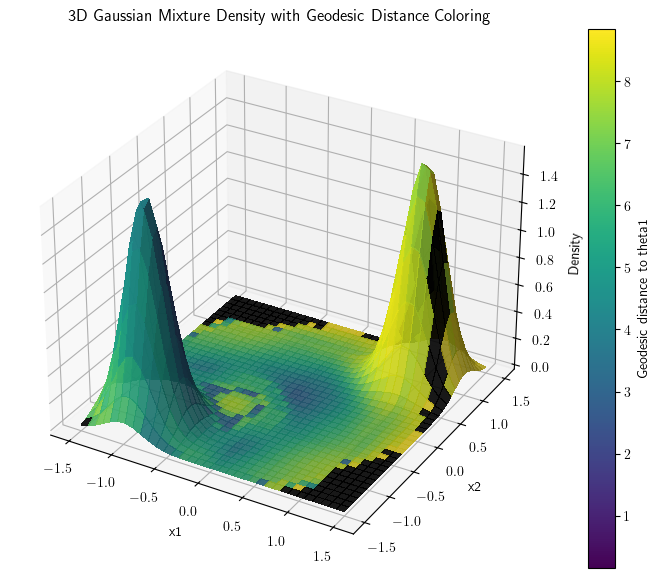

In [10]:
'''
Plot results 
'''
cmap_upper =1
dist_norm = np.clip(distances, 0, cmap_upper) / cmap_upper  # normalize 0..1
#dist_norm =  distances / distances.max()

# --- 3D surface plot ---
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    X1, X2, density.detach().numpy(),
    facecolors=plt.cm.viridis(dist_norm),
    rstride=1, cstride=1, linewidth=0, antialiased=False, alpha=0.9
)

m = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
#m.set_clim(0, cmap_upper)           # clip colorbar
m.set_array(distances)              
plt.colorbar(m, ax=ax, label='Geodesic distance to theta1')

# Axis labels
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Density')
ax.set_title('3D Gaussian Mixture Density with Geodesic Distance Coloring')

plt.show()